In [1]:

from __future__ import division
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from pybasicbayes.distributions import Regression
from pybasicbayes.util.text import progprint_xrange
from autoregressive.distributions import AutoRegression

from scipy.io import loadmat
import glob, os
from scipy.io import savemat # store results for comparison with Matlab code   
from scipy.linalg import solve_discrete_lyapunov as dtlyap # solve discrete-time Lyapunov equation

absolute_code_path = '/home/marcel/Desktop/Projects/Stitching/code/pyLDS_dev/'
os.chdir(absolute_code_path +'pylds')

from pylds.models import LDS, DefaultLDS
from pylds.distributions import Regression_diag, AutoRegression_input
from pylds.obs_scheme import ObservationScheme
from pylds.user_util import gen_pars, rand_rotation_matrix, init_LDS_model, collect_LDS_stats

def update(model):
    model.EM_step()
    return model.log_likelihood() 

# Fit models for illustration #1

In [ ]:
filenames = glob.glob("*.npz")
num_exps = len(filenames)
idx_exps = range(num_exps)

def update(model):
    model.EM_step()
    return model.log_likelihood()
        
eps = np.log(1.01)
max_iter = 25

#initialisers = ['params', 'params_flip', 'params_naive', 'params_naive_flip', 'random']
initialisers = ['params', 'params_flip', 'random']

for i in idx_exps:
    
    ##################
    # load the data  #
    ##################
    
    filename = filenames[i]

    os.chdir('../data/')    
    loadfile = np.load(filename)

    data = loadfile['y']
    T,p = data.shape
    n   = loadfile['x'].shape[1]
    obs_scheme = ObservationScheme(p=p, T=T, 
                                   sub_pops=tuple([item for item in loadfile['sub_pops']]),
                                   obs_pops=loadfile['obs_pops'], 
                                   obs_time=loadfile['obs_time'])
    pars_true = loadfile['truePars'].reshape(1,)[0] # some numpy (cross-version 3.x-2.x?)     
    tmp = {}
    for j in range(len(pars_true.keys())):
        tmp[str(pars_true.keys()[j])] =  pars_true.values()[j]
    pars_true = tmp    

    print('dataset #', i)
    print('(T, p, n, eps) = ', (T, p, n, eps))
    
    ####################
    # pick initialiser #
    ####################

    
    for initialiser in initialisers:
        
        print('initialiser ', initialiser)

        if initialiser in ['params', 'params_flip', 'params_naive', 'params_naive_flip']:
            os.chdir('../init/')

            num_reps = 1
            
            loadfile = np.load('init_'+filename)

            initkey =  initialiser[:-5] if initialiser[-5:]=='_flip' else initialiser
            
            pars_init = loadfile[initkey].reshape(1,)[0]
            tmp = {}
            for j in range(len(pars_init.keys())):
                tmp[str(pars_init.keys()[j])] =  pars_init.values()[j]
            pars_init = tmp    

            pars_init['R'] = np.diag(pars_init['R'])
            
            # for SSID-derived initialisers, also try out flipping parts of C
            if initialiser[-5:]=='_flip':
                idx0_no_overlap = np.setdiff1d(np.arange(p),obs_scheme.sub_pops[1]) 
                pars_init['C'][idx0_no_overlap,:] *= -1


        elif initialiser=='random':
            
            num_reps = 10
            
        else:
            raise Exception('unexpected initialiser!')

        
        for rep in range(num_reps):

            print( 'run #' + str(rep+1) +'/' +str(num_reps) )
            
            if initialiser=='random':

                pars_init, _ = gen_pars(n, p, u_dim=0, 
                                     pars_in=None, 
                                     obs_scheme=obs_scheme,
                                     gen_A='diagonal', lts=0.99 * np.ones((n,)),
                                     gen_B='random', 
                                     gen_Q='identity', 
                                     gen_mu0='random', 
                                     gen_V0='identity', 
                                     gen_C='random', 
                                     gen_d='mean', 
                                     gen_R='fractionObserved',
                                     diag_R_flag=True,
                                     x=None, y=data.T, u=None)    

            ###################
            #    EM cycles    #
            ###################

            try:
                # get EM-step results after m iterations                    
                model = init_LDS_model(pars_init, data, obs_scheme) # reset to initialisation                    
                print 'fitting #' + str(i)    
                likes = [-np.inf]
                for t in progprint_xrange(max_iter):
                    likes.append(update(model))
                    if likes[-1]-likes[-2] < eps:
                        break

                stats_hat,pars_hat = collect_LDS_stats(model)

                # get EM-step results from true parameters
                model = init_LDS_model(pars_true, data, obs_scheme) # reset to true pars
                model.E_step()
                stats_true,_ = collect_LDS_stats(model)
                model.M_step()
                
                broken = False
                y_out = model.states_list[0].data
                x_out = model.states_list[0].stateseq
                Pi = dtlyap(pars_true['A'], pars_true['Q'])
                Pi_h = dtlyap(pars_hat['A'], pars_hat['Q'])
                Pi_t = pars_true['A'].dot(dtlyap(pars_true['A'], pars_true['Q']))
                Pi_t_h = pars_hat['A'].dot(dtlyap(pars_hat['A'], pars_hat['Q']))
                
                
            except:
                print('')
                print('############')
                print('#RUN BROKE!#')
                print('############')
                print('')
                
                broken = True
                y_out = model.states_list[0].data
                x_out = []
                pars_hat, stats_h, stats_true = [],[],[]
                Pi, Pi_h, Pi_t, Pi_t_h = 0,0,0,0
                
            ###################
            #  store results  #
            ###################

            print('finished in ' + str(len(likes)-1) + ' many steps.')

            os.chdir('../fits/')

            save_file = initialiser + '_idx' + str(rep) + '_' + filename

            save_file_m = {'ifBroken':broken,
                           'x': x_out, 
                           'y': y_out,
                           'u' : [], 
                           'll' : likes, 
                           'T' : model.states_list[0].T, 
                           'Trial': len(model.states_list), 
                           'ifUseB':False, 
                           'ifUseA':True, 
                           'epsilon':eps,
                           'truePars':pars_true,
                           'initPars':pars_init,
                           'estPars': pars_hat,
                           'stats_h': stats_hat,
                           'stats_true': stats_true,
                           'Pi':Pi,
                           'Pi_h':Pi_h,
                           'Pi_t':Pi_t,
                           'Pi_t_h':Pi_t_h,
                           'obsScheme' : obs_scheme}
            savemat(save_file,save_file_m) # does the actual saving

            np.savez(save_file, 
                    broken=broken,
                    x=x_out,
                    y=y_out,
                    ll=likes,
                    T=model.states_list[0].T, 
                    Trial=len(model.states_list), 
                    ifUseA=True,
                    ifUseB=False,
                    epsilon=eps,
                    initPars=pars_init,
                    truePars=pars_true,
                    estPars =pars_hat,
                    stats_h = stats_hat,
                    stats_true = stats_true,
                    Pi=Pi,
                    Pi_h=Pi_h,
                    Pi_t=Pi_t,
                    Pi_t_h=Pi_t_h,
                    sub_pops=obs_scheme.sub_pops,            
                    obs_time=obs_scheme.obs_time,            
                    obs_pops=obs_scheme.obs_pops)     



# Fit models for simulation #1

In [ ]:
relative_data_path = '../../../results/cosyne_poster/simulation_1/data'
os.chdir(relative_data_path)
filenames = glob.glob("*.npz")
num_exps = len(filenames)
idx_exps = range(num_exps)

def update(model):
    model.EM_step()
    return model.log_likelihood()
        
eps = np.log(1.01)
max_iter = 25

initialisers = ['params', 'params_flip', 'params_naive', 'params_naive_flip', 'random']

for i in idx_exps:
    
    ##################
    # load the data  #
    ##################
    
    filename = filenames[i]

    os.chdir('../data/')    
    loadfile = np.load(filename)

    data = loadfile['y']
    T,p = data.shape
    n   = loadfile['x'].shape[1]
    sub_pops = tuple([item for item in loadfile['sub_pops']])
    obs_pops = loadfile['obs_pops']

    pars_true = loadfile['truePars'].reshape(1,)[0] # some numpy (cross-version 3.x-2.x?)     
    tmp = {}
    for j in range(len(pars_true.keys())):
        tmp[str(pars_true.keys()[j])] =  pars_true.values()[j]
    pars_true = tmp    

    print('dataset #', i)
    print('(T, p, n, eps) = ', (T, p, n, eps))
    
    ####################
    # pick initialiser #
    ####################

    
    for initialiser in initialisers:
        
        print('initialiser ', initialiser)

        if initialiser in ['params', 'params_flip', 'params_naive', 'params_naive_flip']:
            os.chdir('../init/')

            num_reps = 1
            
            loadfile = np.load('init_'+filename)

            initkey =  initialiser[:-5] if initialiser[-5:]=='_flip' else initialiser
            
            pars_init = loadfile[initkey].reshape(1,)[0]
            tmp = {}
            for j in range(len(pars_init.keys())):
                tmp[str(pars_init.keys()[j])] =  pars_init.values()[j]
            pars_init = tmp    

            pars_init['R'] = np.diag(pars_init['R'])
            
            # for SSID-derived initialisers, also try out flipping parts of C
            if initialiser[-5:]=='_flip':
                idx0_no_overlap = np.setdiff1d(np.arange(p),obs_scheme.sub_pops[1]) 
                pars_init['C'][idx0_no_overlap,:] *= -1


        elif initialiser=='random':
            
            num_reps = 10
            
        else:
            raise Exception('unexpected initialiser!')

        
        for rep in range(num_reps):

            print( 'run #' + str(rep+1) +'/' +str(num_reps) )
            
            if initialiser=='random':

                pars_init, _ = gen_pars(n, p, u_dim=0, 
                                     pars_in=None, 
                                     obs_scheme=obs_scheme,
                                     gen_A='diagonal', lts=0.99 * np.ones((n,)),
                                     gen_B='random', 
                                     gen_Q='identity', 
                                     gen_mu0='random', 
                                     gen_V0='identity', 
                                     gen_C='random', 
                                     gen_d='mean', 
                                     gen_R='fractionObserved',
                                     diag_R_flag=True,
                                     x=None, y=data.T, u=None)    

            ###################
            #    EM cycles    #
            ###################

            try:
                
                # get EM-step results from true parameters
                model = init_LDS_model(pars_true, data, obs_scheme) # reset to true pars
                model.E_step()
                stats_true,_ = collect_LDS_stats(model)
                
                # get EM-step results after m iterations                    
                model = init_LDS_model(pars_init, data, obs_scheme) # reset to initialisation                    
                print 'fitting #' + str(i)    
                likes = [-np.inf]
                for t in progprint_xrange(max_iter):
                    likes.append(update(model))
                    if likes[-1]-likes[-2] < eps:
                        break

                stats_hat,pars_hat = collect_LDS_stats(model)
                
                broken = False
                y_out = model.states_list[0].data
                x_out = model.states_list[0].stateseq
                Pi = dtlyap(pars_true['A'], pars_true['Q'])
                Pi_h = dtlyap(pars_hat['A'], pars_hat['Q'])
                Pi_t = pars_true['A'].dot(dtlyap(pars_true['A'], pars_true['Q']))
                Pi_t_h = pars_hat['A'].dot(dtlyap(pars_hat['A'], pars_hat['Q']))
                
                
            except:
                print('')
                print('############')
                print('#RUN BROKE!#')
                print('############')
                print('')
                
                broken = True
                y_out = []
                x_out = []
                pars_hat, stats_hat, stats_true = [],[],[]
                Pi, Pi_h, Pi_t, Pi_t_h = 0,0,0,0
                
            ###################
            #  store results  #
            ###################

            print('finished in ' + str(len(likes)-1) + ' many steps.')

            os.chdir('../fits/')

            save_file = initialiser + '_idx' + str(rep) + '_' + filename

            save_file_m = {'ifBroken':broken,
                           'x': x_out, 
                           'y': y_out,
                           'u' : [], 
                           'll' : likes, 
                           'T' : model.states_list[0].T, 
                           'Trial': len(model.states_list), 
                           'ifUseB':False, 
                           'ifUseA':True, 
                           'epsilon':eps,
                           'truePars':pars_true,
                           'initPars':pars_init,
                           'estPars': pars_hat,
                           'stats_h': stats_hat,
                           'stats_true': stats_true,
                           'Pi':Pi,
                           'Pi_h':Pi_h,
                           'Pi_t':Pi_t,
                           'Pi_t_h':Pi_t_h,
                           'obsScheme' : obs_scheme}
            savemat(save_file,save_file_m) # does the actual saving

            np.savez(save_file, 
                    broken=broken,
                    ll=likes,
                    T=model.states_list[0].T, 
                    Trial=len(model.states_list), 
                    ifUseA=True,
                    ifUseB=False,
                    epsilon=eps,
                    initPars=pars_init,
                    truePars=pars_true,
                    estPars =pars_hat,
                    stats_h = stats_hat,
                    stats_true = stats_true,
                    Pi=Pi,
                    Pi_h=Pi_h,
                    Pi_t=Pi_t,
                    Pi_t_h=Pi_t_h,
                    sub_pops=obs_scheme.sub_pops,            
                    obs_time=obs_scheme.obs_time,            
                    obs_pops=obs_scheme.obs_pops)     



# Fit models for simulation #2

('idx', 0)
LDS_save_idx0.npz
('dataset #', 0)
('(T, p, n, eps) = ', (5000, 50, 5, 0.009950330853168092))
prot 0/36
('initialiser ', 'params')
run #1/1
fitting #0
.........................  [ 25/50,    0.14sec avg, ETA 3.43 ]
.........................  [ 50/50,    0.14sec avg, ETA 0.00 ]

   0.14sec avg, 6.98 total



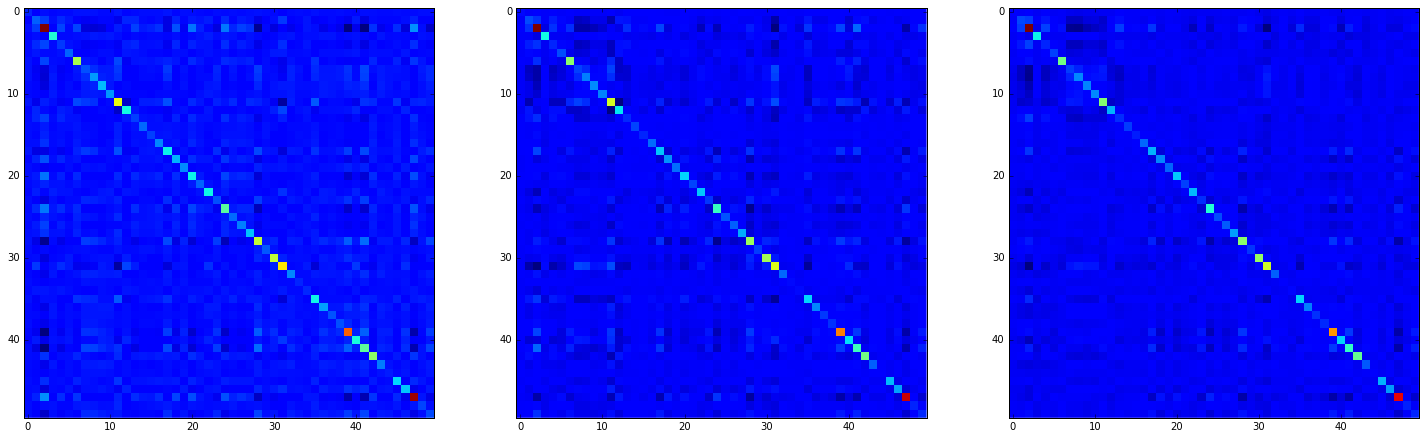

finished in 50 many steps.
('initialiser ', 'params_flip')
run #1/1
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.27 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.52 total



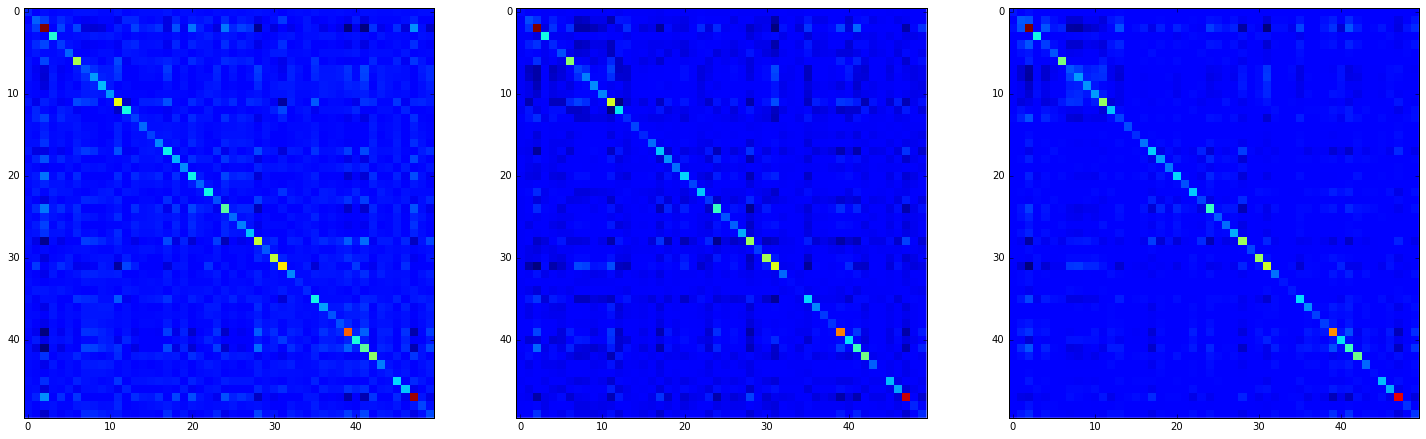

finished in 50 many steps.
('initialiser ', 'params_naive')
run #1/1
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.25 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.50 total



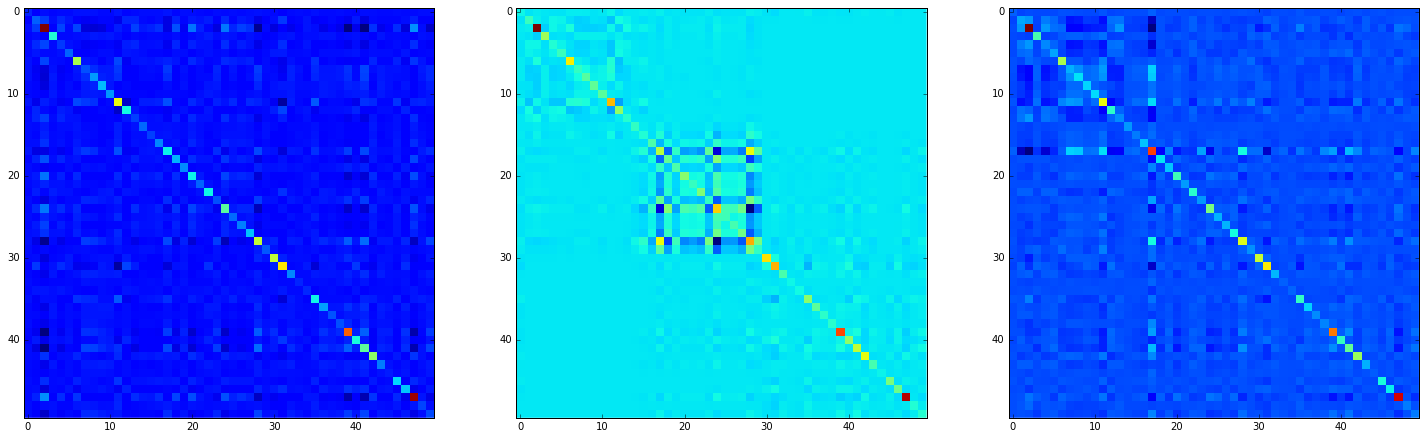

finished in 50 many steps.
('initialiser ', 'params_naive_flip')
run #1/1
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.27 ]
.........................  [ 50/50,    0.11sec avg, ETA 0.00 ]

   0.11sec avg, 5.34 total



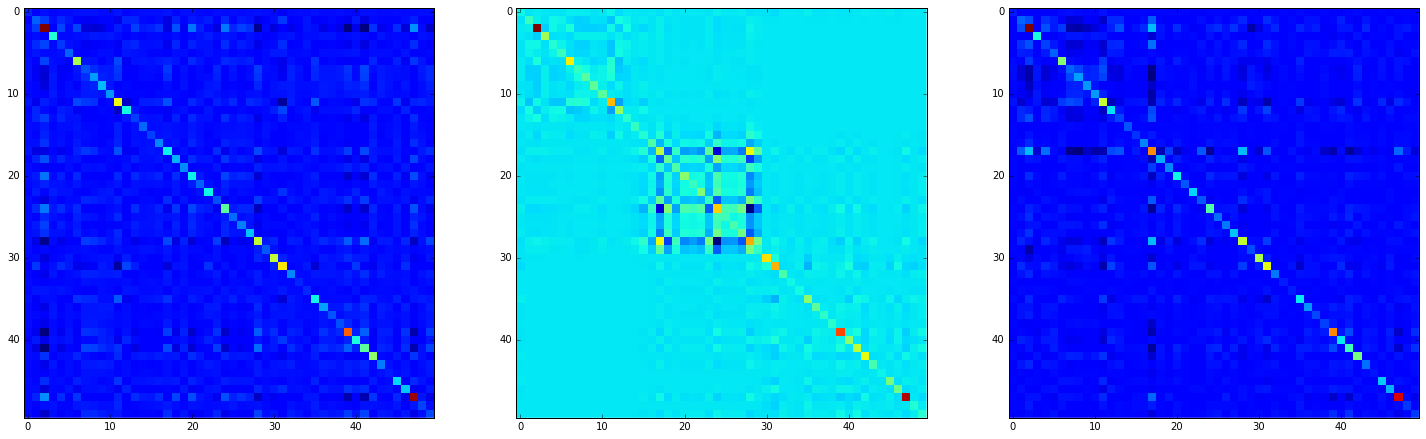

finished in 50 many steps.
('initialiser ', 'random')
run #1/5
fitting #0
.........................  [ 25/50,    0.10sec avg, ETA 2.44 ]
.........................  [ 50/50,    0.12sec avg, ETA 0.00 ]

   0.12sec avg, 5.99 total



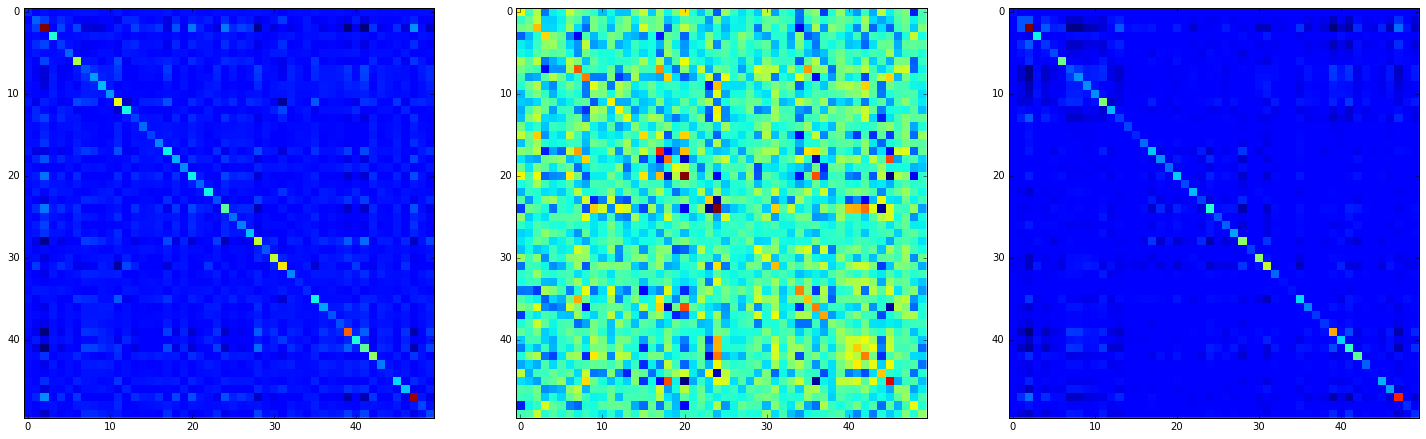

finished in 50 many steps.
run #2/5
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.24 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.50 total



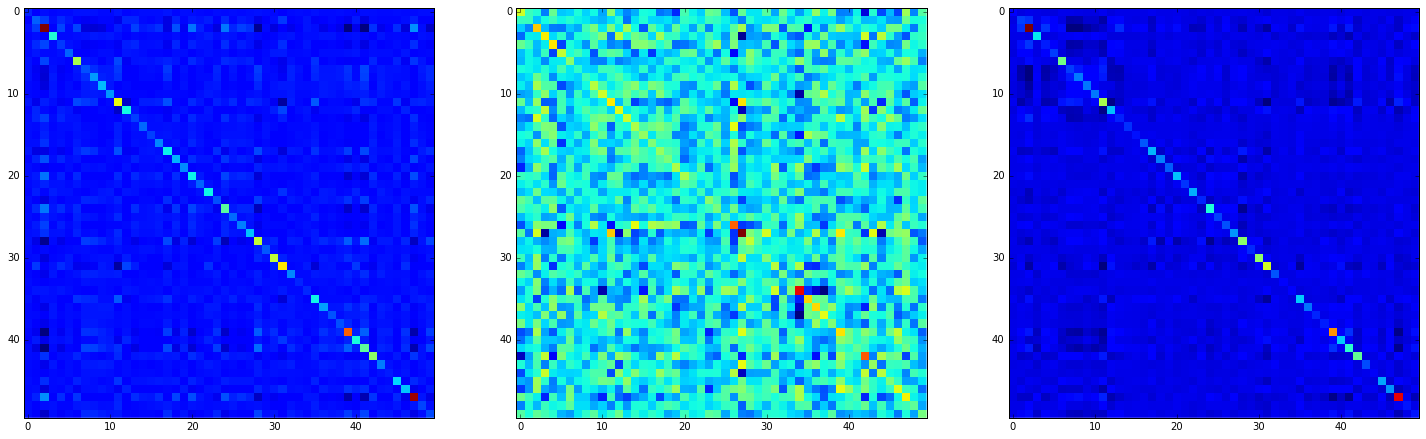

finished in 50 many steps.
run #3/5
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.23 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.45 total



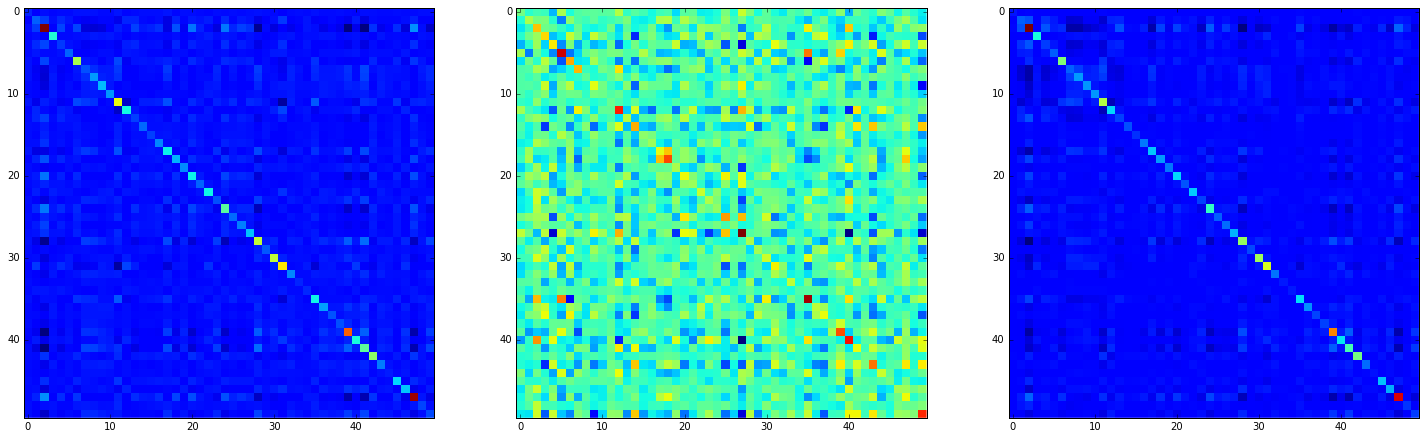

finished in 50 many steps.
run #4/5
fitting #0
.........................  [ 25/50,    0.12sec avg, ETA 2.90 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.42 total



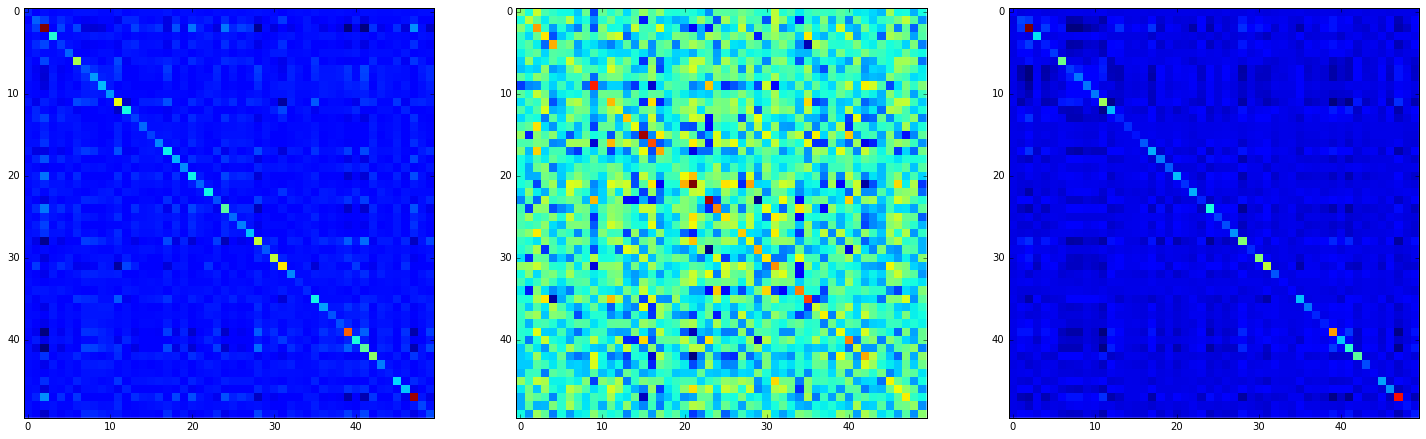

finished in 50 many steps.
run #5/5
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.28 ]
.........................  [ 50/50,    0.10sec avg, ETA 0.00 ]

   0.10sec avg, 5.03 total



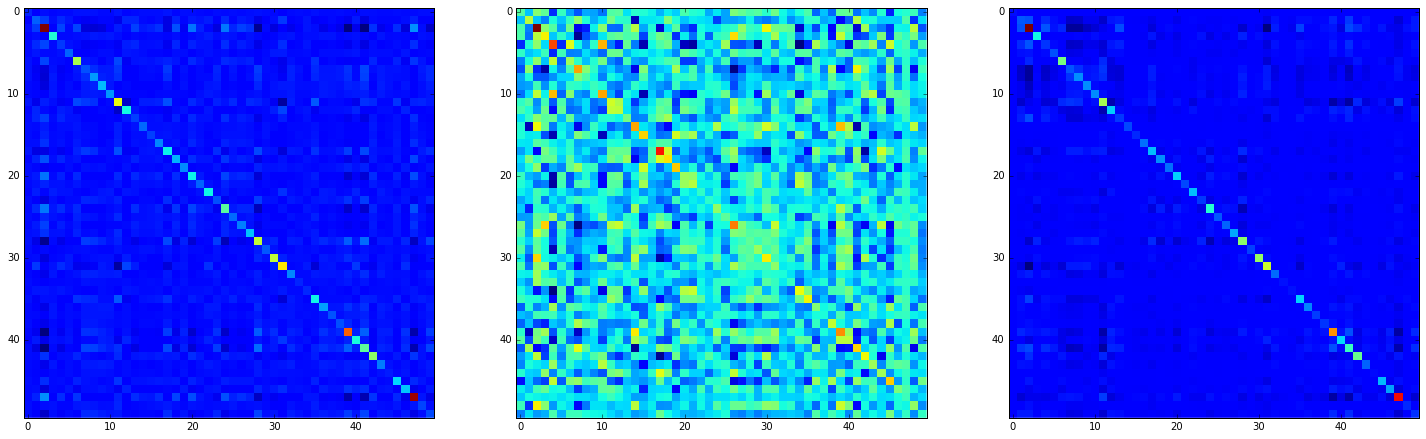

finished in 50 many steps.
prot 12/36
('initialiser ', 'params')
run #1/1
fitting #0
.........................  [ 25/50,    0.10sec avg, ETA 2.56 ]
.........................  [ 50/50,    0.12sec avg, ETA 0.00 ]

   0.12sec avg, 5.93 total



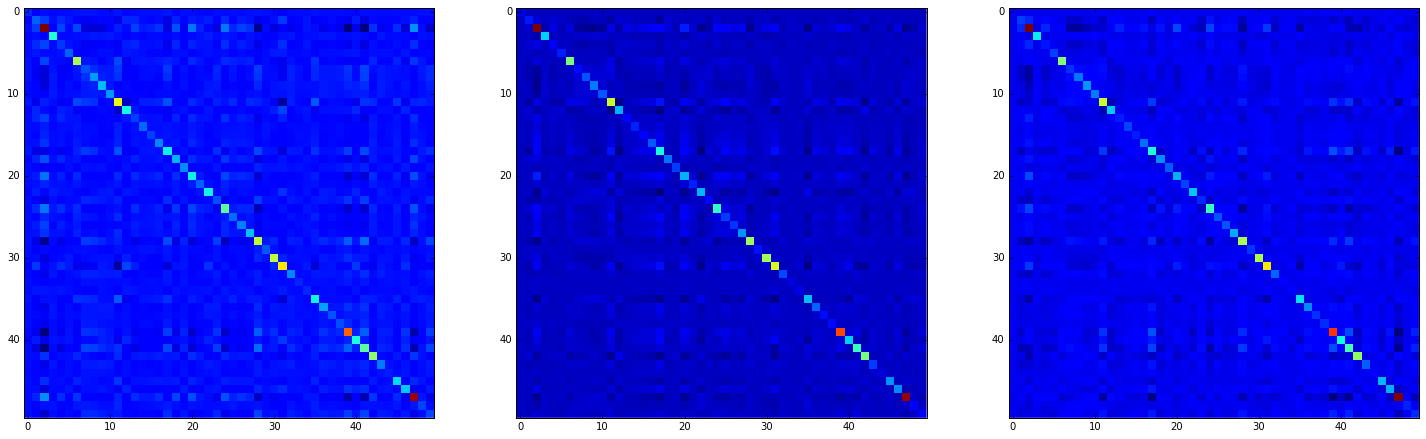

finished in 50 many steps.
('initialiser ', 'params_flip')
run #1/1
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.17 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.33 total



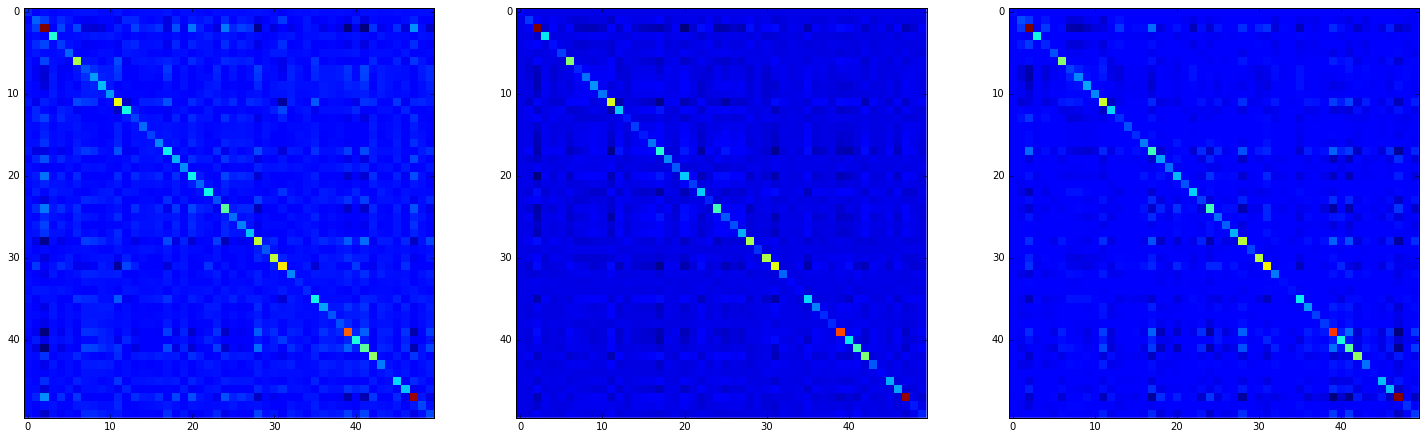

finished in 50 many steps.
('initialiser ', 'params_naive')
run #1/1
fitting #0
.........................  [ 25/50,    0.08sec avg, ETA 2.12 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.24 total



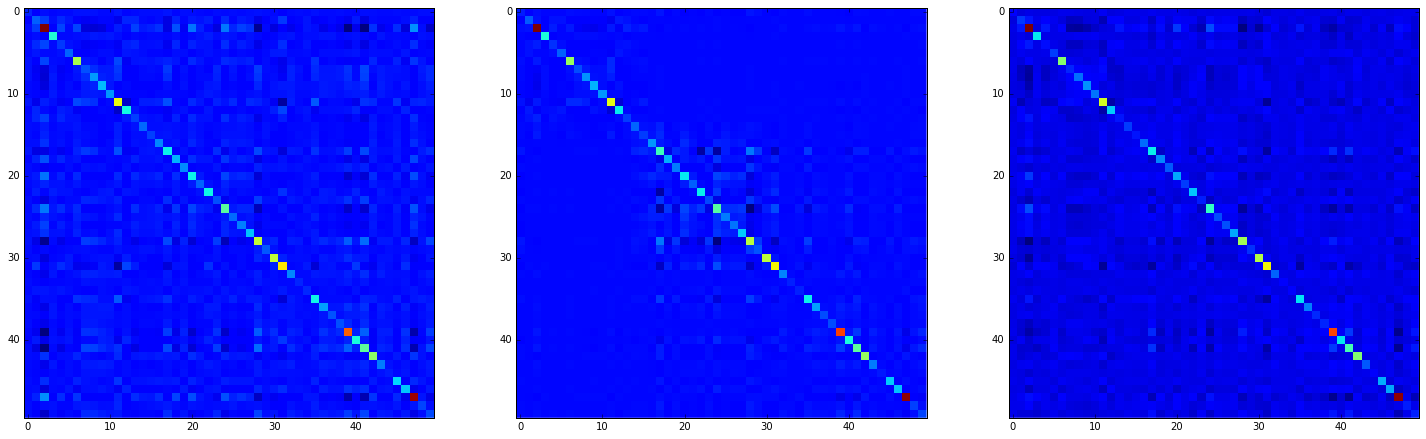

finished in 50 many steps.
('initialiser ', 'params_naive_flip')
run #1/1
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.14 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.27 total



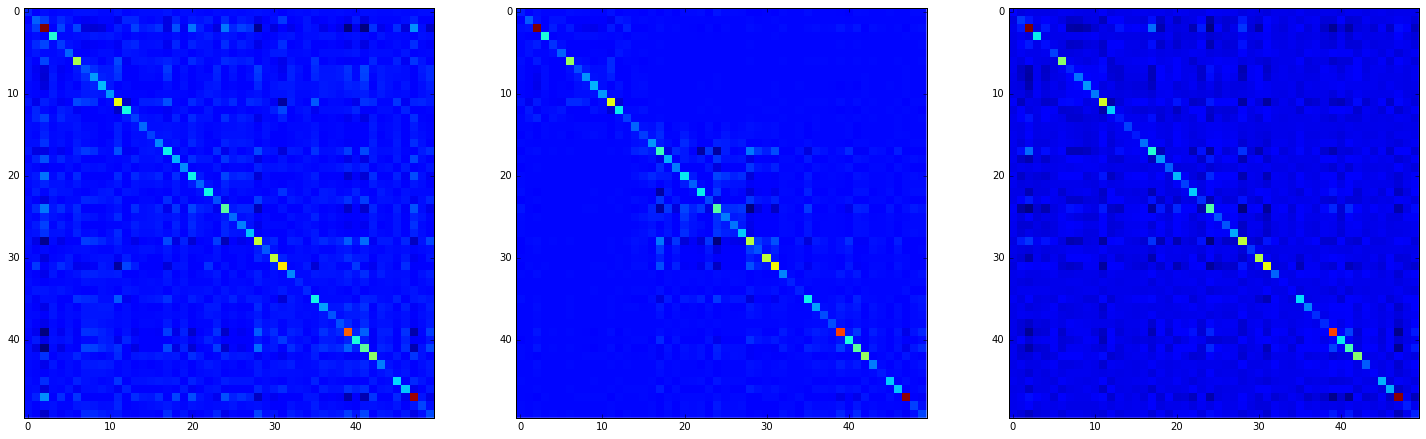

finished in 50 many steps.
('initialiser ', 'random')
run #1/5
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.31 ]
.........................  [ 50/50,    0.11sec avg, ETA 0.00 ]

   0.11sec avg, 5.69 total



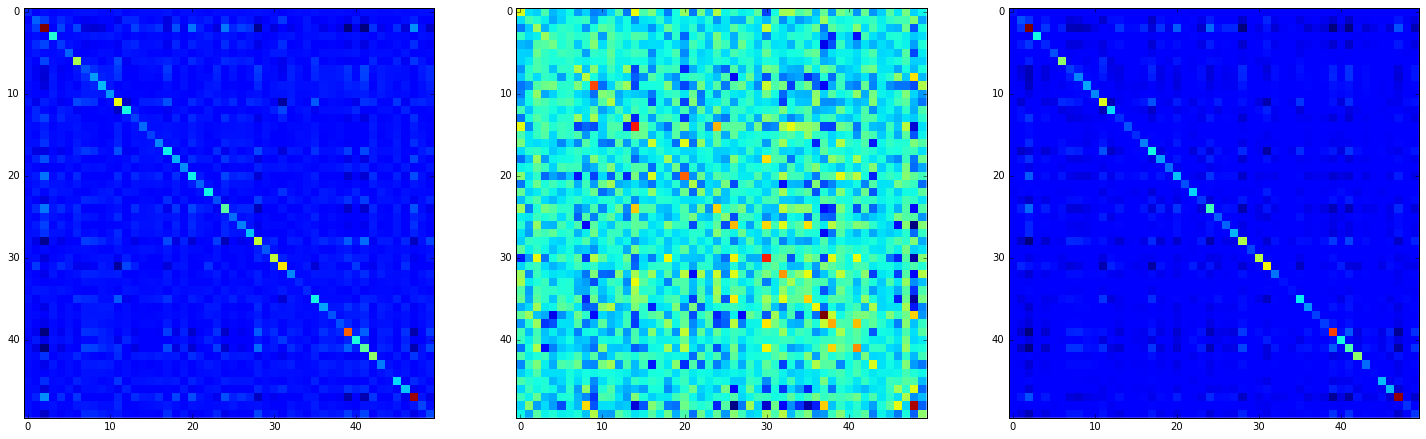

finished in 50 many steps.
run #2/5
fitting #0
.........................  [ 25/50,    0.14sec avg, ETA 3.43 ]
.........................  [ 50/50,    0.12sec avg, ETA 0.00 ]

   0.12sec avg, 6.11 total



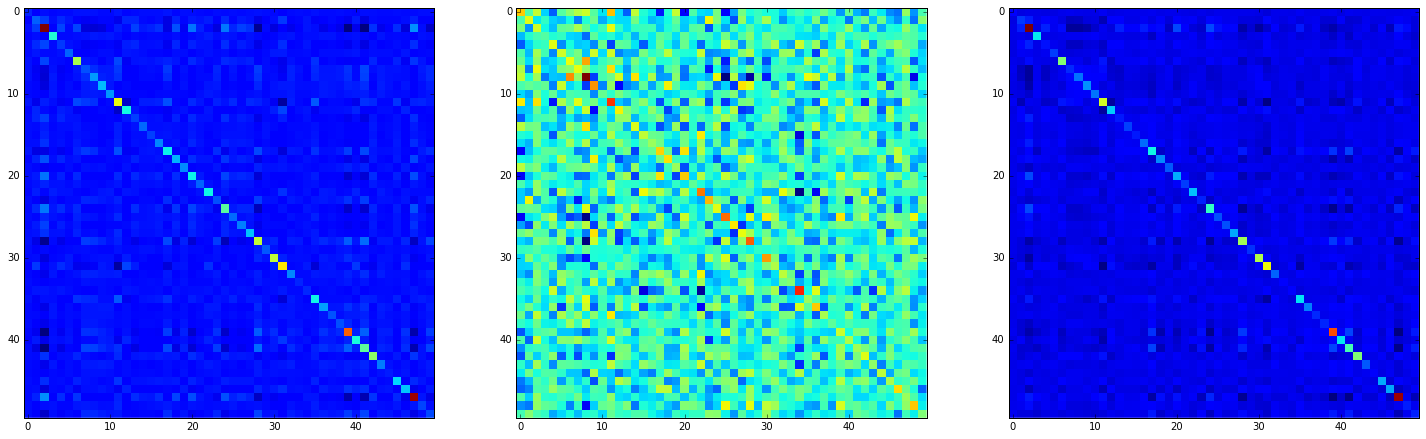

finished in 50 many steps.
run #3/5
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.20 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.43 total



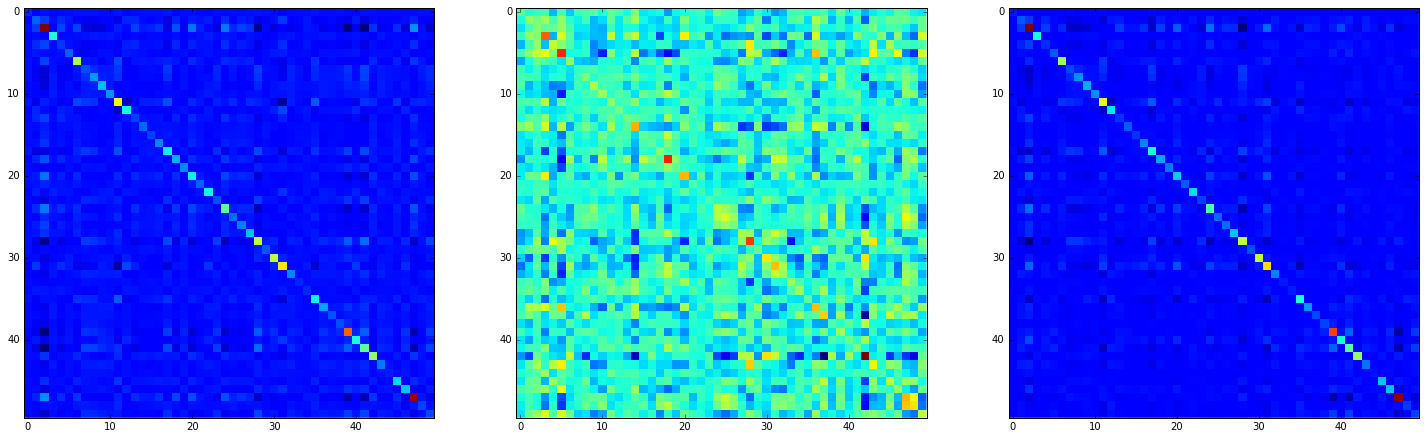

finished in 50 many steps.
run #4/5
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.19 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.36 total



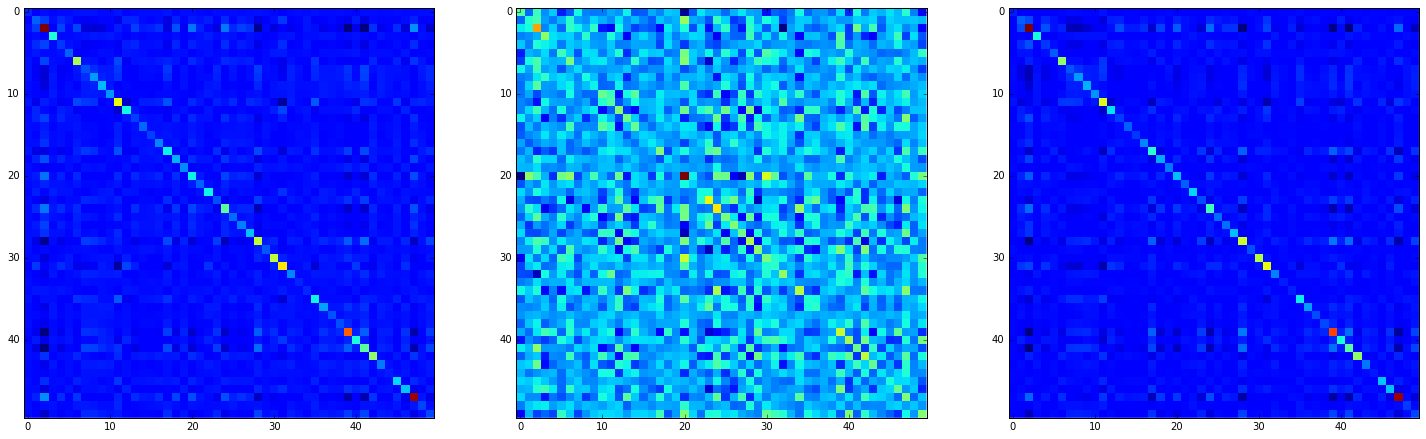

finished in 50 many steps.
run #5/5
fitting #0
.........................  [ 25/50,    0.09sec avg, ETA 2.17 ]
.........................  [ 50/50,    0.10sec avg, ETA 0.00 ]

   0.10sec avg, 5.10 total



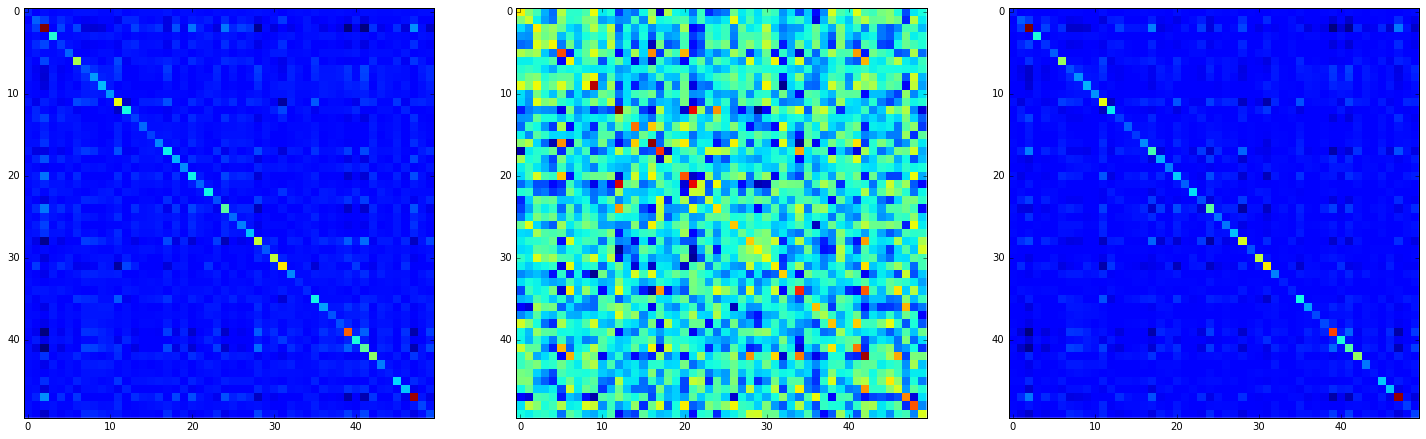

finished in 50 many steps.
('idx', 2)
LDS_save_idx2.npz
('dataset #', 2)
('(T, p, n, eps) = ', (5000, 50, 5, 0.009950330853168092))
prot 0/36
('initialiser ', 'params')
run #1/1
fitting #2
.........................  [ 25/50,    0.13sec avg, ETA 3.31 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.65 total



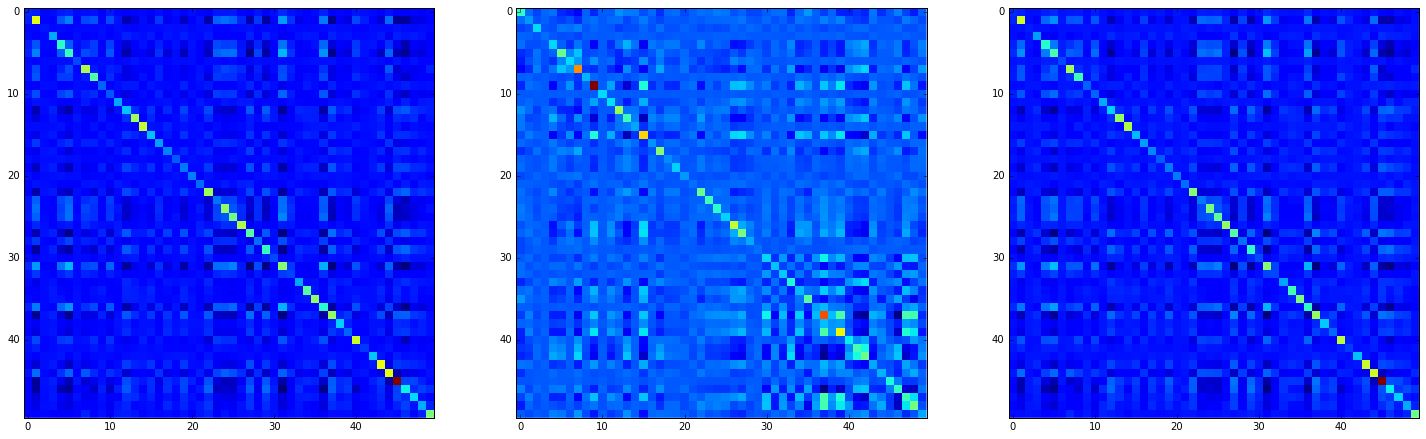

finished in 50 many steps.
('initialiser ', 'params_flip')
run #1/1
fitting #2
.........................  [ 25/50,    0.09sec avg, ETA 2.15 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.28 total



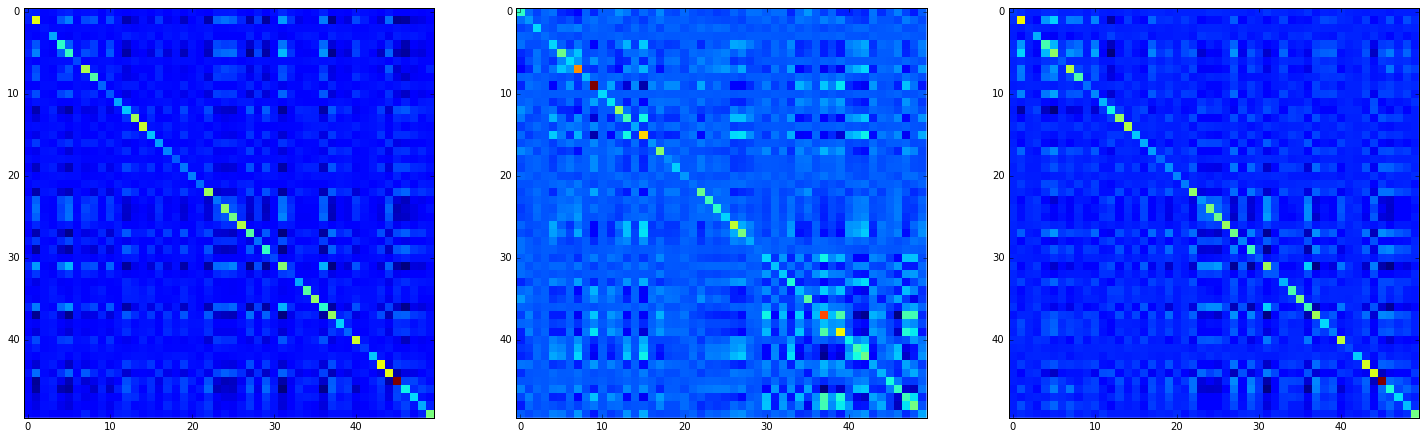

finished in 50 many steps.
('initialiser ', 'params_naive')
run #1/1
fitting #2
.........................  [ 25/50,    0.09sec avg, ETA 2.14 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.27 total



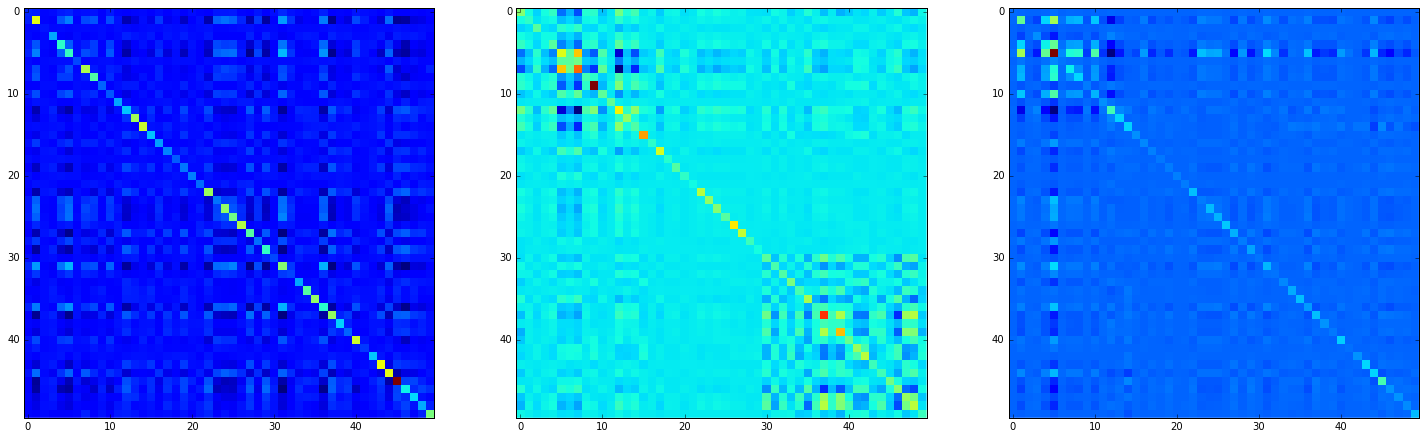

finished in 50 many steps.
('initialiser ', 'params_naive_flip')
run #1/1
fitting #2
.........................  [ 25/50,    0.09sec avg, ETA 2.13 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.26 total



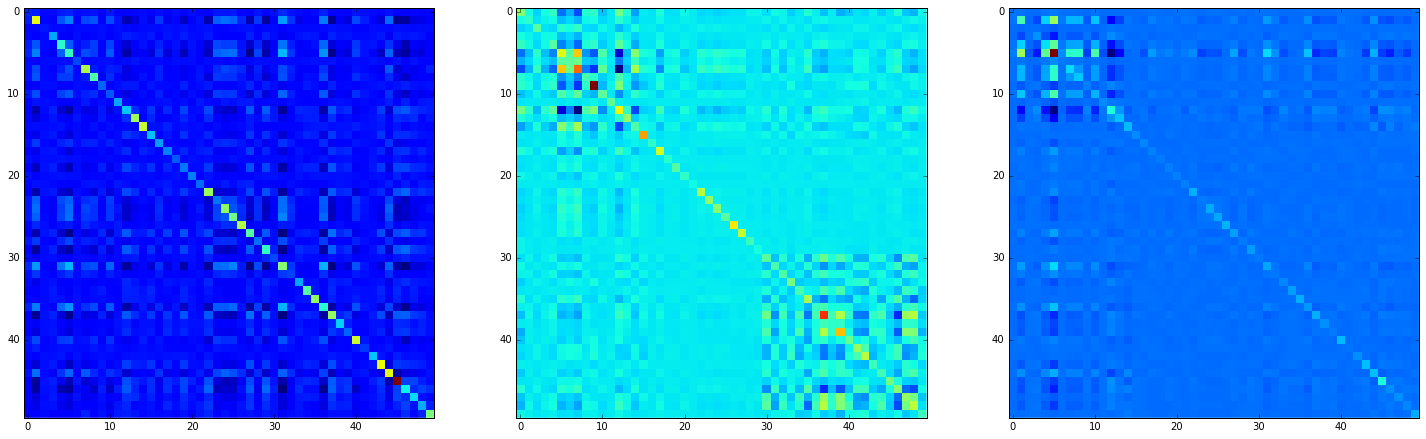

finished in 50 many steps.
('initialiser ', 'random')
run #1/5
fitting #2
.........................  [ 25/50,    0.08sec avg, ETA 2.12 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.22 total



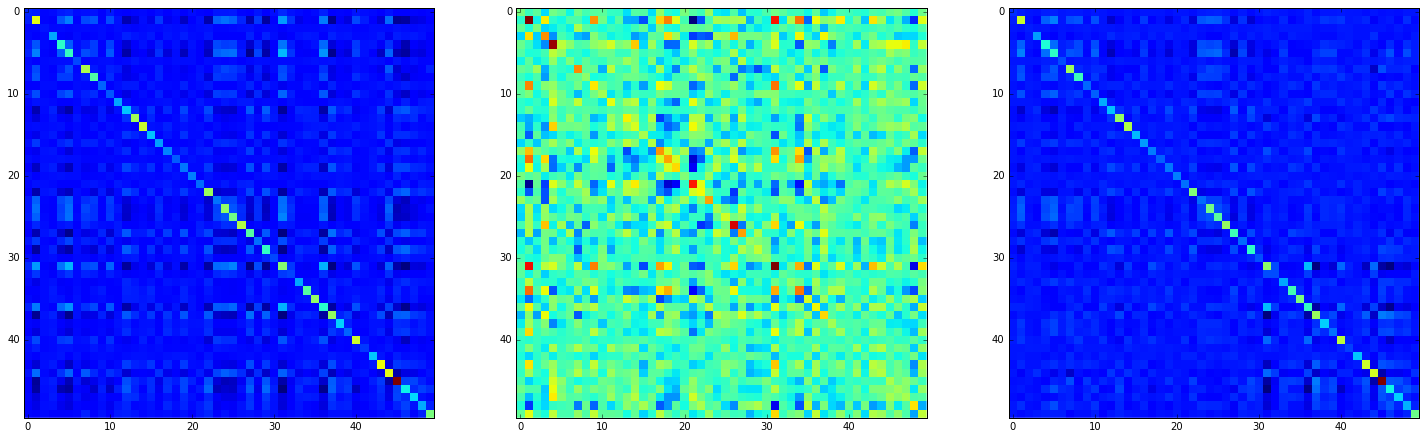

finished in 50 many steps.
run #2/5
fitting #2
.........................  [ 25/50,    0.13sec avg, ETA 3.15 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.45 total



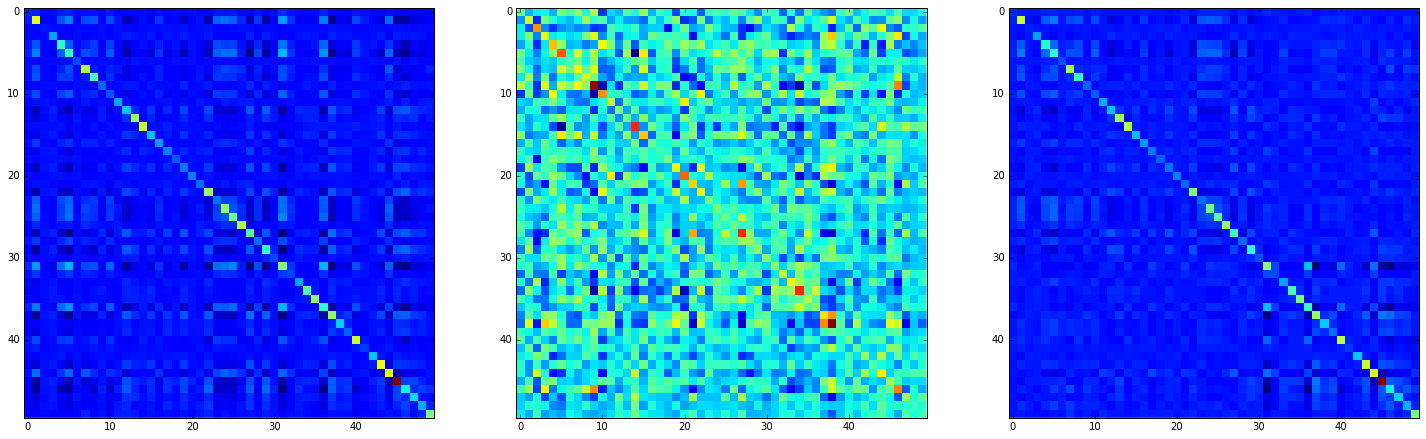

finished in 50 many steps.
run #3/5
fitting #2
.........................  [ 25/50,    0.13sec avg, ETA 3.36 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.68 total



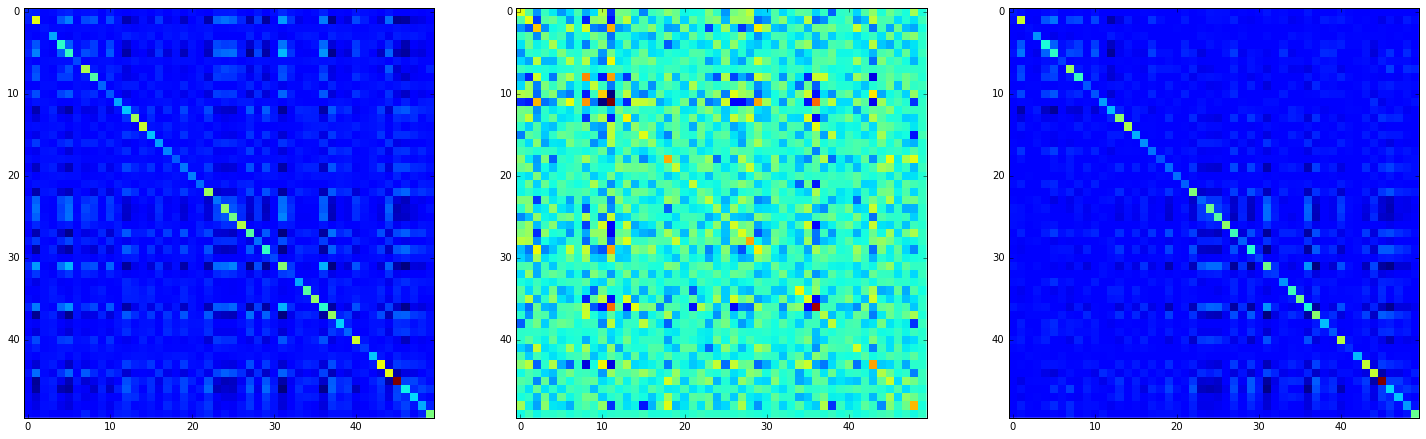

finished in 50 many steps.
run #4/5
fitting #2
.........................  [ 25/50,    0.14sec avg, ETA 3.38 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.71 total



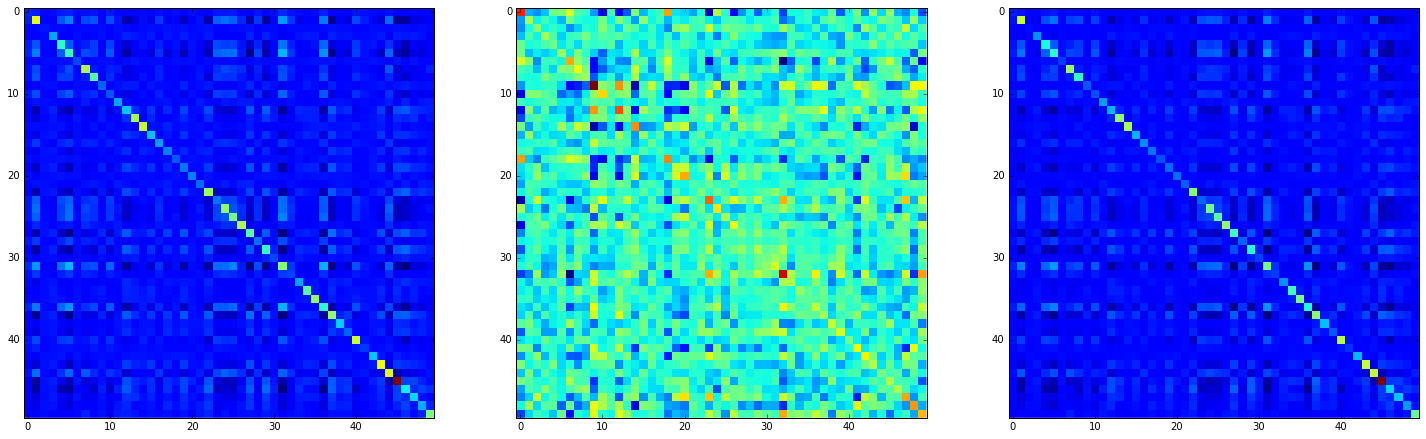

finished in 50 many steps.
run #5/5
fitting #2
.........................  [ 25/50,    0.09sec avg, ETA 2.14 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.28 total



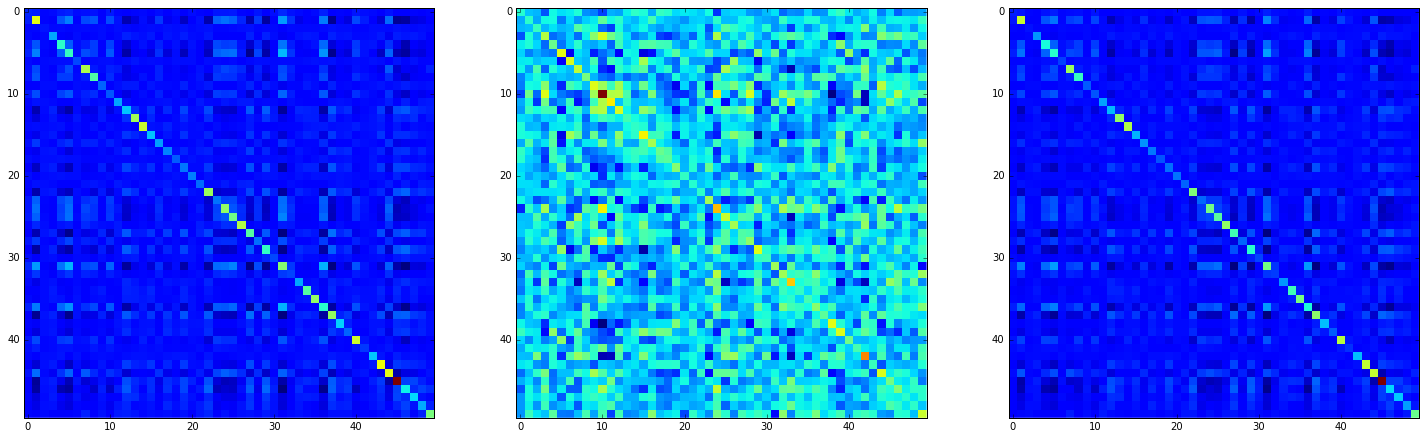

finished in 50 many steps.
prot 12/36
('initialiser ', 'params')
run #1/1
fitting #2
.........................  [ 25/50,    0.08sec avg, ETA 2.10 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.19 total



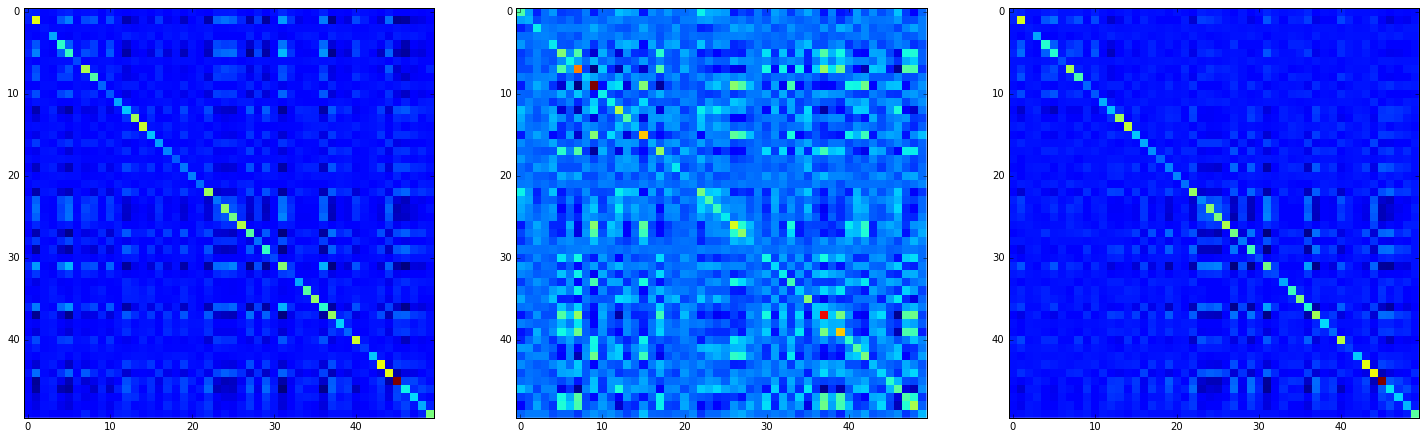

finished in 50 many steps.
('initialiser ', 'params_flip')
run #1/1
fitting #2
.........................  [ 25/50,    0.08sec avg, ETA 2.08 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.16 total



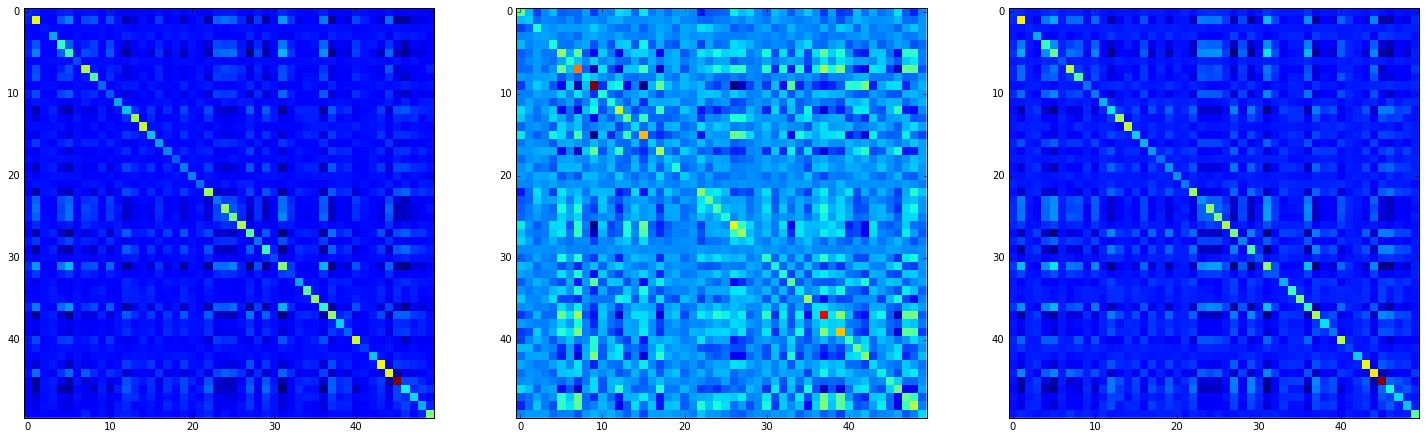

finished in 50 many steps.
('initialiser ', 'params_naive')
run #1/1
fitting #2
.........................  [ 25/50,    0.08sec avg, ETA 2.10 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.18 total



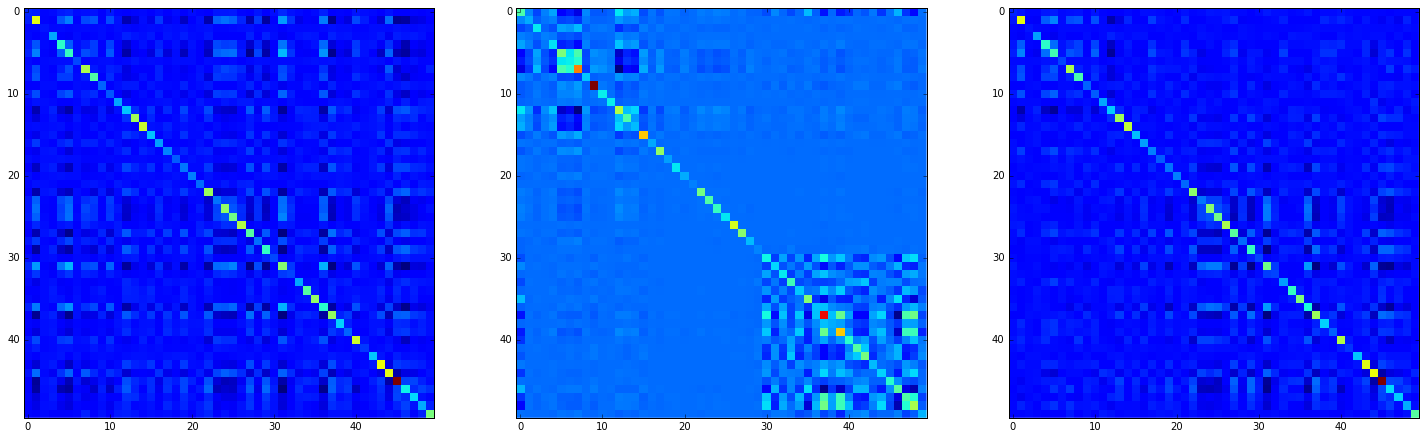

finished in 50 many steps.
('initialiser ', 'params_naive_flip')
run #1/1
fitting #2
.........................  [ 25/50,    0.08sec avg, ETA 2.07 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.12 total



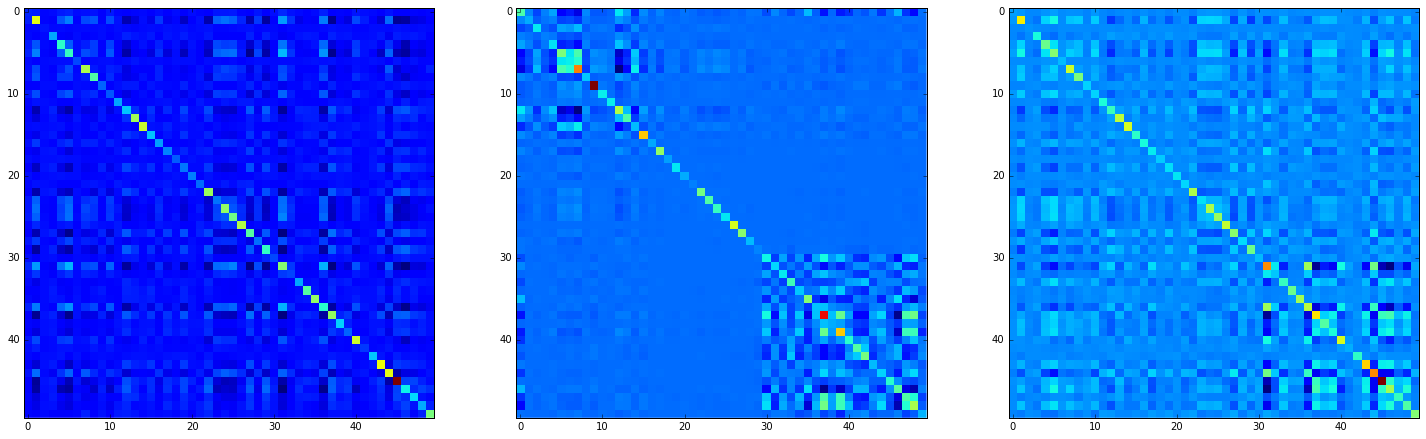

finished in 50 many steps.
('initialiser ', 'random')
run #1/5
fitting #2
.........................  [ 25/50,    0.12sec avg, ETA 3.10 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.33 total



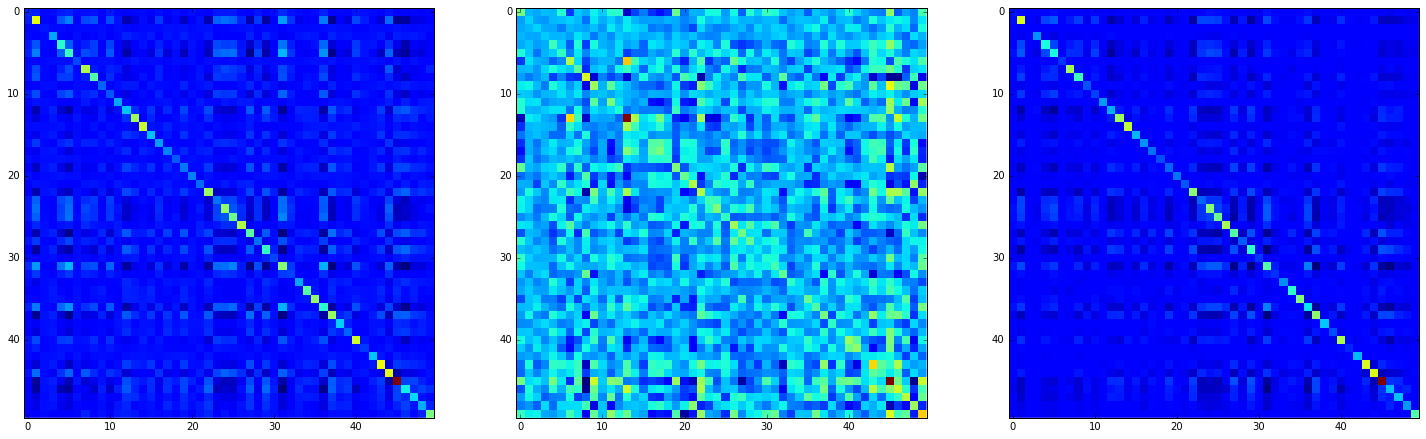

finished in 50 many steps.
run #2/5
fitting #2
.........................  [ 25/50,    0.13sec avg, ETA 3.23 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.45 total



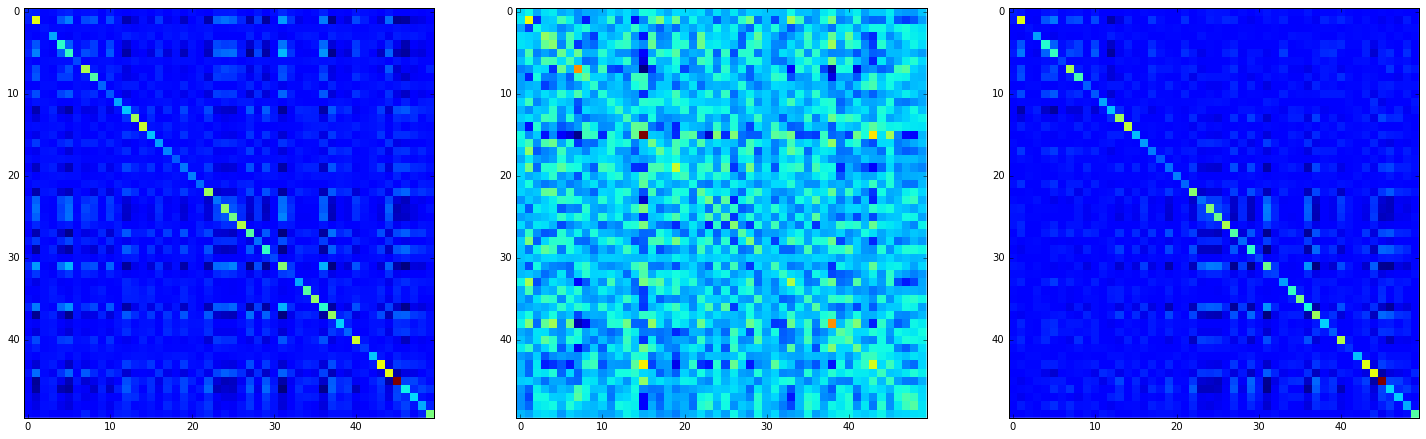

finished in 50 many steps.
run #3/5
fitting #2
.........................  [ 25/50,    0.13sec avg, ETA 3.21 ]
.........................  [ 50/50,    0.11sec avg, ETA 0.00 ]

   0.11sec avg, 5.58 total



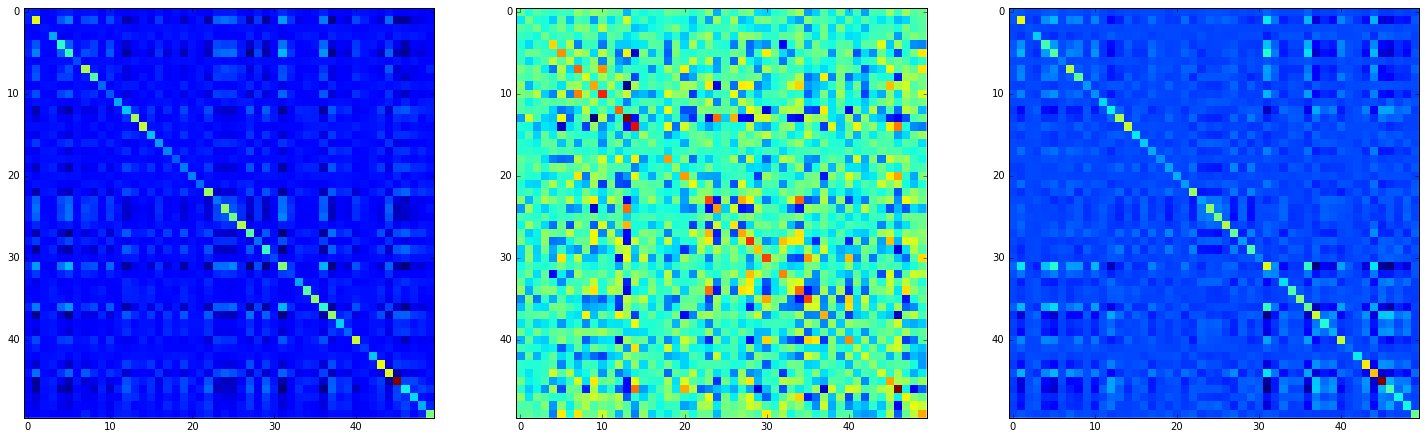

finished in 50 many steps.
run #4/5
fitting #2
.........................  [ 25/50,    0.09sec avg, ETA 2.33 ]
.........................  [ 50/50,    0.11sec avg, ETA 0.00 ]

   0.11sec avg, 5.54 total



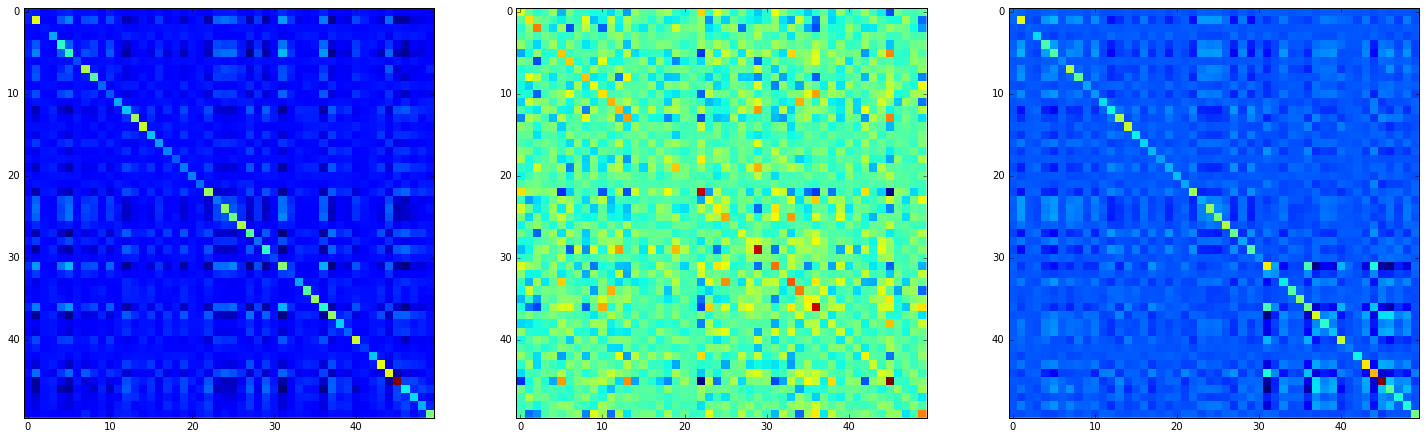

finished in 50 many steps.
run #5/5
fitting #2
.........................  [ 25/50,    0.13sec avg, ETA 3.21 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.42 total



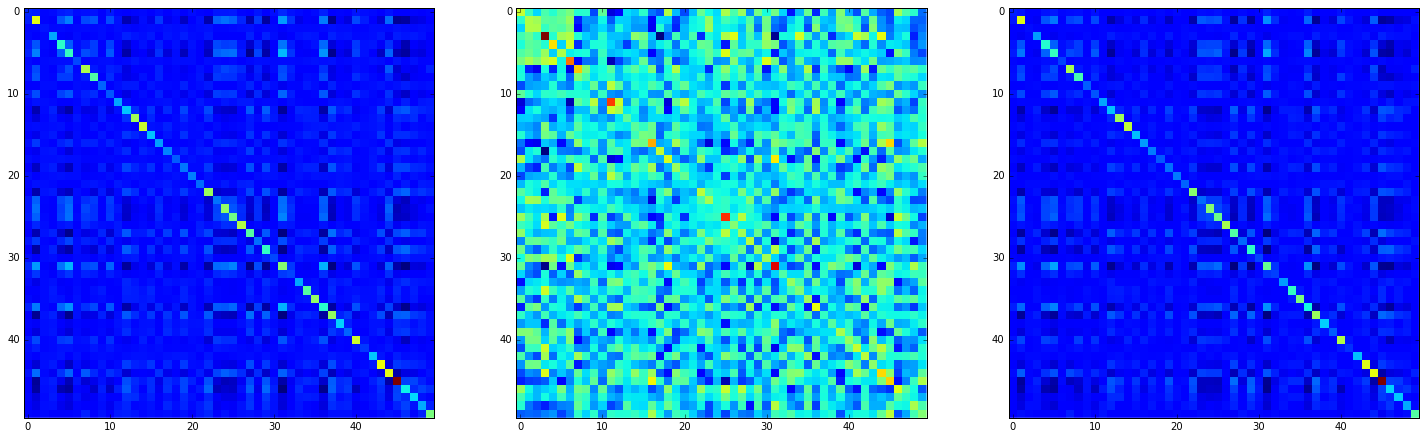

finished in 50 many steps.
('idx', 5)
LDS_save_idx5.npz
('dataset #', 5)
('(T, p, n, eps) = ', (5000, 50, 5, 0.009950330853168092))
prot 0/36
('initialiser ', 'params')
run #1/1
fitting #5
.........................  [ 25/50,    0.14sec avg, ETA 3.41 ]
.........................  [ 50/50,    0.14sec avg, ETA 0.00 ]

   0.14sec avg, 6.87 total



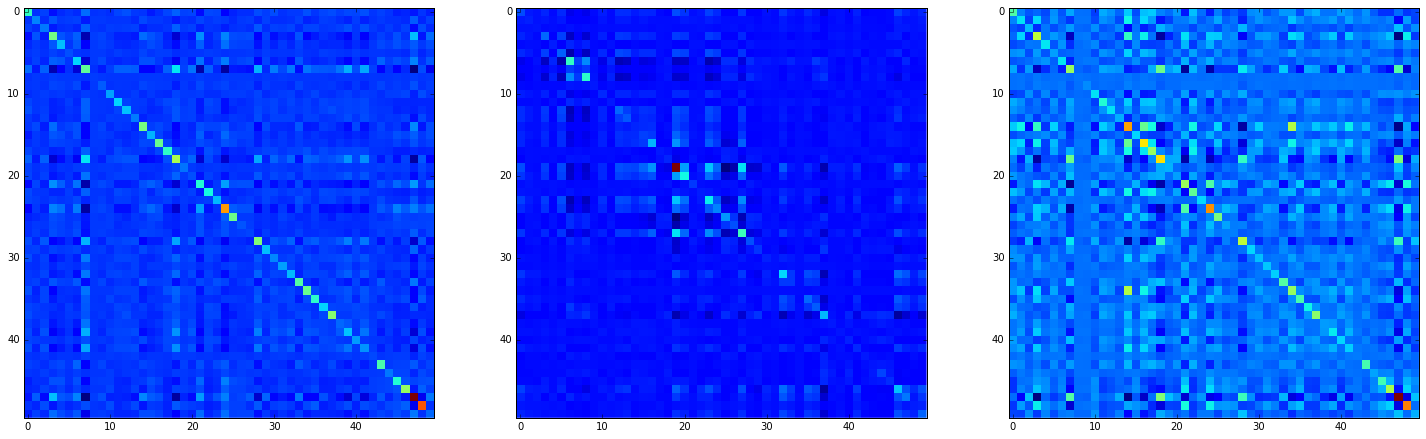

finished in 50 many steps.
('initialiser ', 'params_flip')
run #1/1
fitting #5
.........................  [ 25/50,    0.14sec avg, ETA 3.42 ]
.........................  [ 50/50,    0.14sec avg, ETA 0.00 ]

   0.14sec avg, 6.87 total



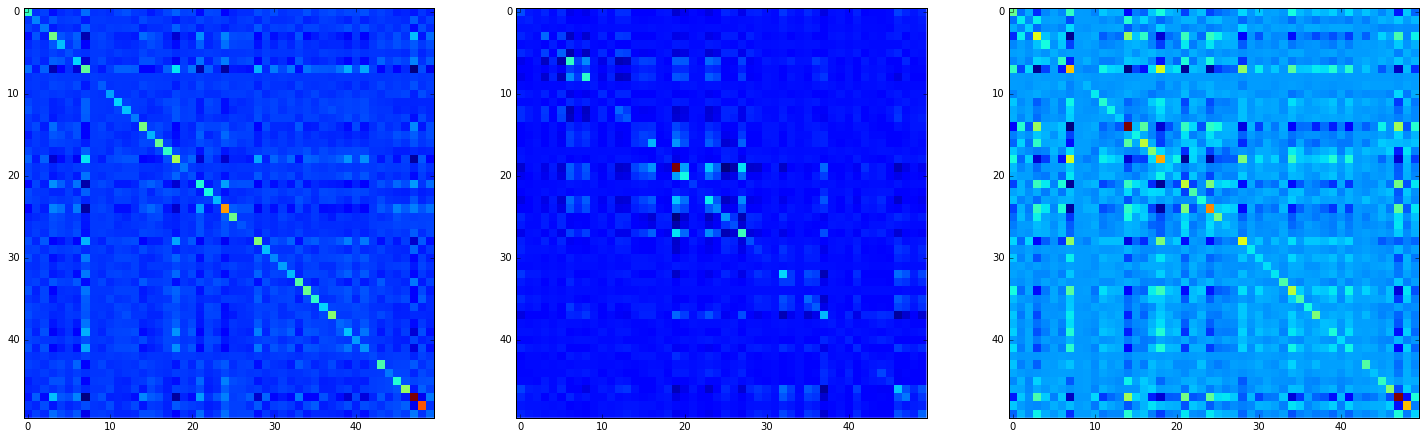

finished in 50 many steps.
('initialiser ', 'params_naive')
run #1/1
fitting #5
.........................  [ 25/50,    0.14sec avg, ETA 3.41 ]
.........................  [ 50/50,    0.14sec avg, ETA 0.00 ]

   0.14sec avg, 6.86 total



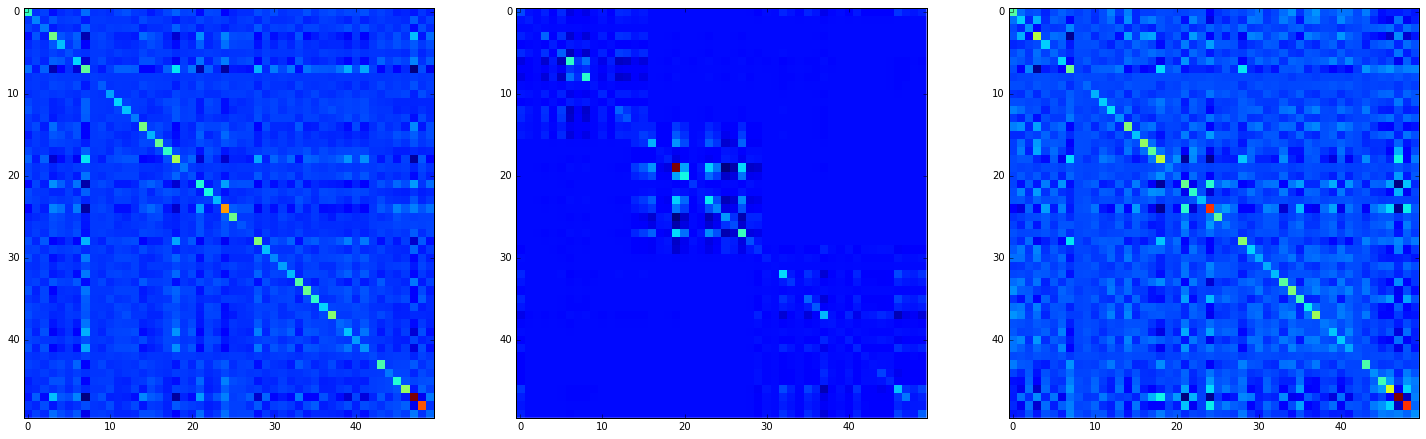

finished in 50 many steps.
('initialiser ', 'params_naive_flip')
run #1/1
fitting #5
.........................  [ 25/50,    0.14sec avg, ETA 3.42 ]
.........................  [ 50/50,    0.14sec avg, ETA 0.00 ]

   0.14sec avg, 6.88 total



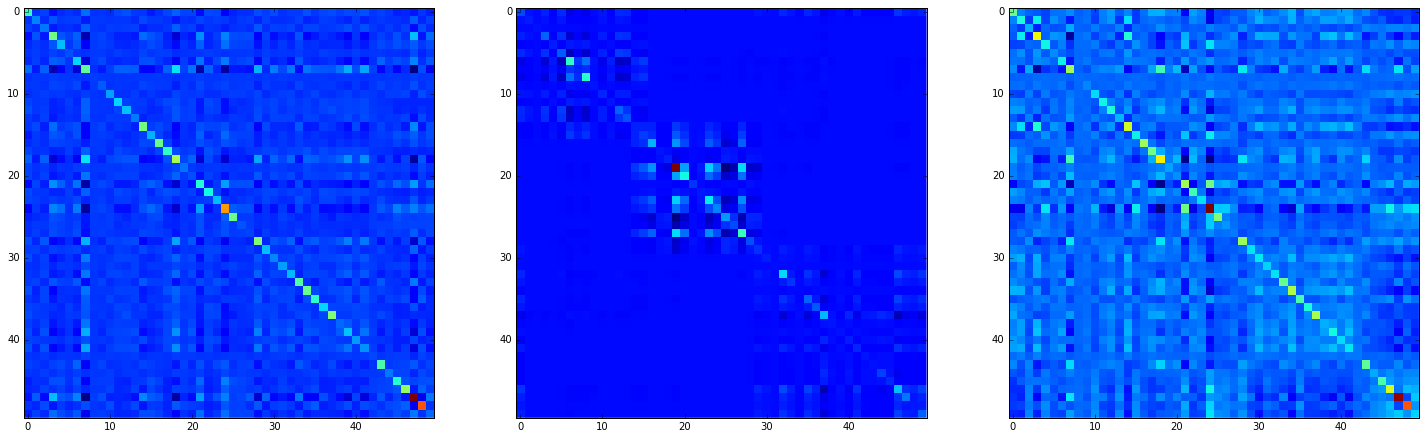

finished in 50 many steps.
('initialiser ', 'random')
run #1/5
fitting #5
.........................  [ 25/50,    0.14sec avg, ETA 3.50 ]
.........................  [ 50/50,    0.14sec avg, ETA 0.00 ]

   0.14sec avg, 7.02 total



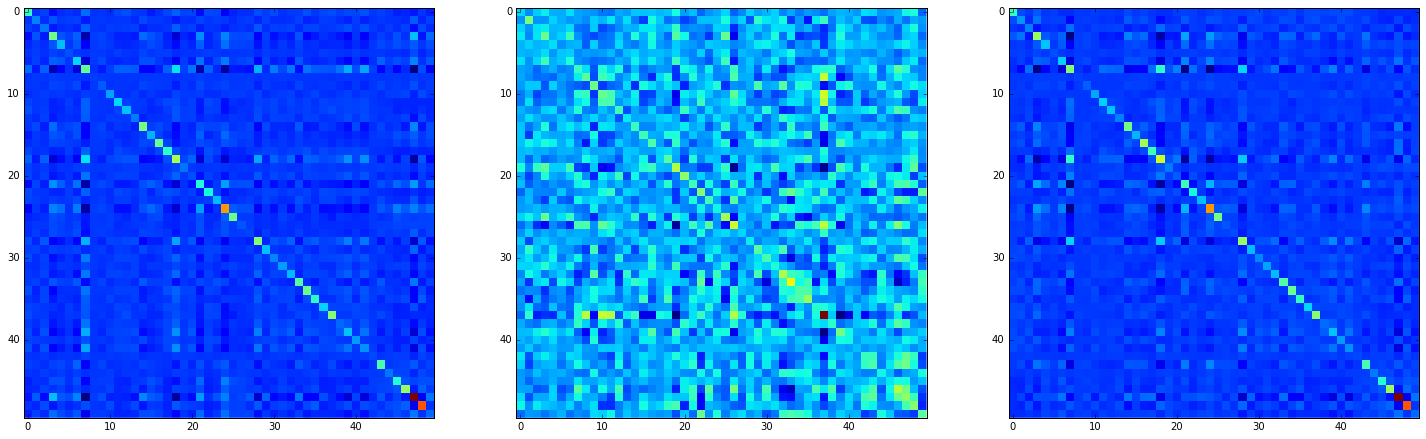

finished in 50 many steps.
run #2/5
fitting #5
.........................  [ 25/50,    0.14sec avg, ETA 3.50 ]
.........................  [ 50/50,    0.14sec avg, ETA 0.00 ]

   0.14sec avg, 7.00 total



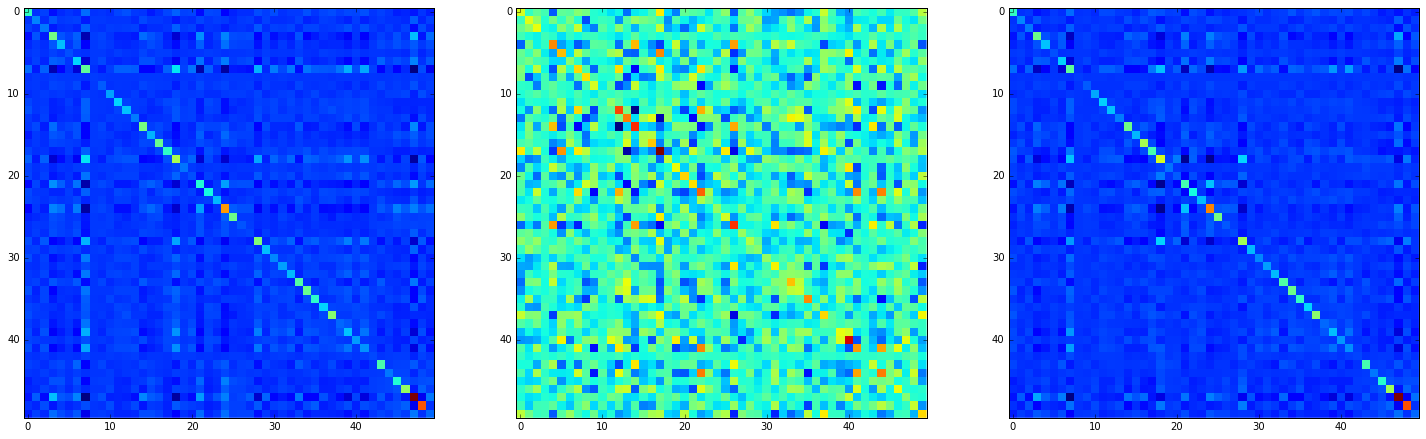

finished in 50 many steps.
run #3/5
fitting #5
.........................  [ 25/50,    0.14sec avg, ETA 3.53 ]
.........................  [ 50/50,    0.14sec avg, ETA 0.00 ]

   0.14sec avg, 7.07 total



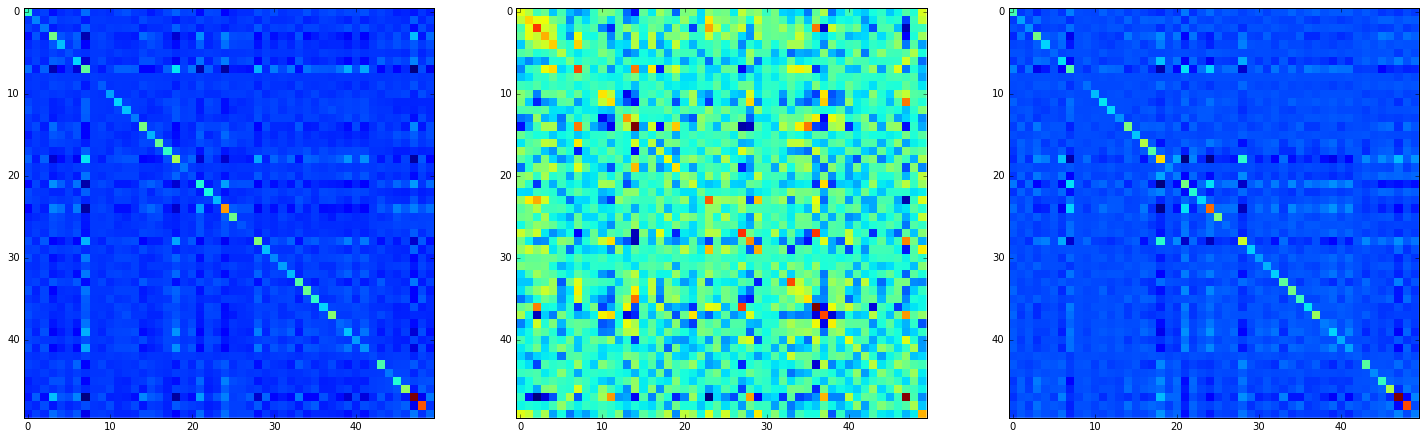

finished in 50 many steps.
run #4/5
fitting #5
.........................  [ 25/50,    0.14sec avg, ETA 3.49 ]
.........................  [ 50/50,    0.14sec avg, ETA 0.00 ]

   0.14sec avg, 6.99 total



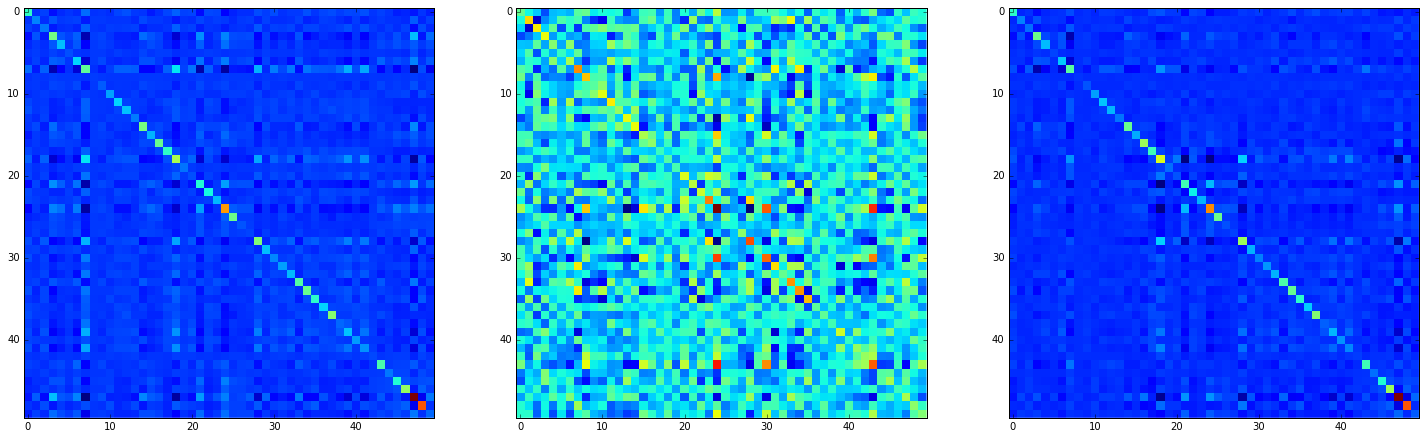

finished in 50 many steps.
run #5/5
fitting #5
.........................  [ 25/50,    0.12sec avg, ETA 3.12 ]
.........................  [ 50/50,    0.11sec avg, ETA 0.00 ]

   0.11sec avg, 5.51 total



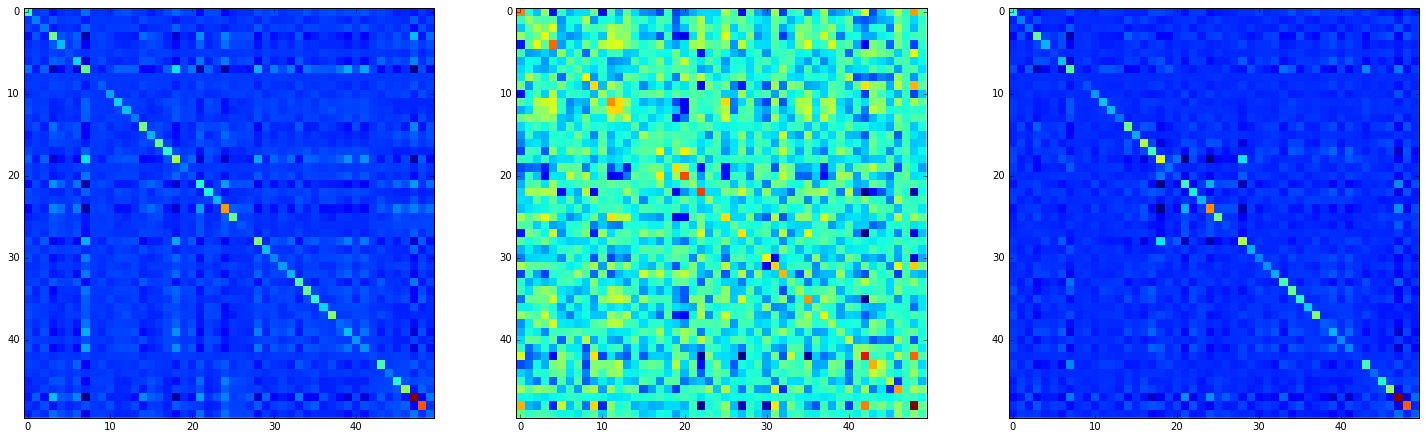

finished in 50 many steps.
prot 12/36
('initialiser ', 'params')
run #1/1
fitting #5
.........................  [ 25/50,    0.09sec avg, ETA 2.30 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.67 total



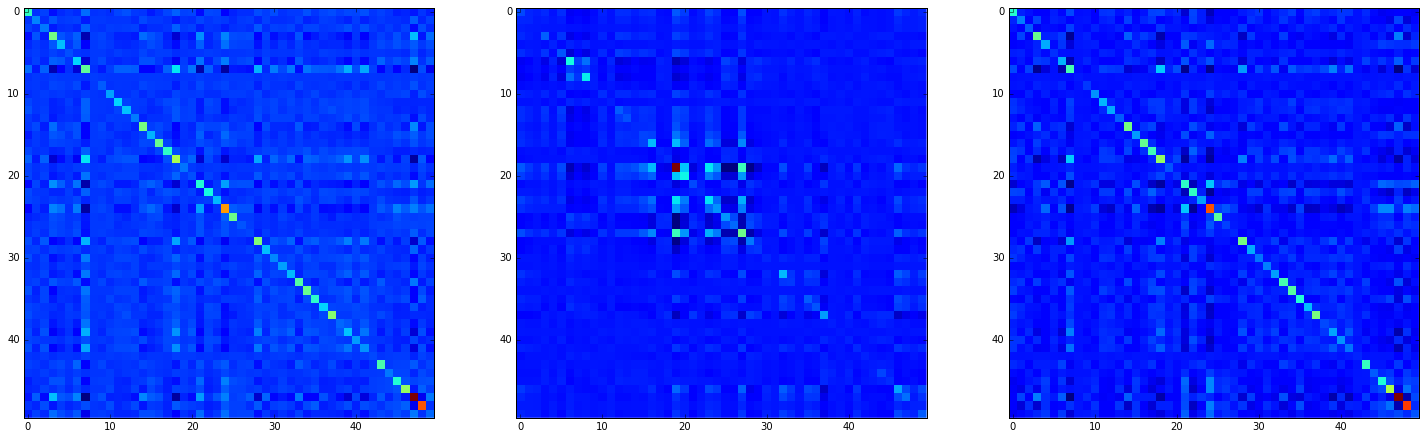

finished in 50 many steps.
('initialiser ', 'params_flip')
run #1/1
fitting #5
.........................  [ 25/50,    0.09sec avg, ETA 2.33 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.67 total



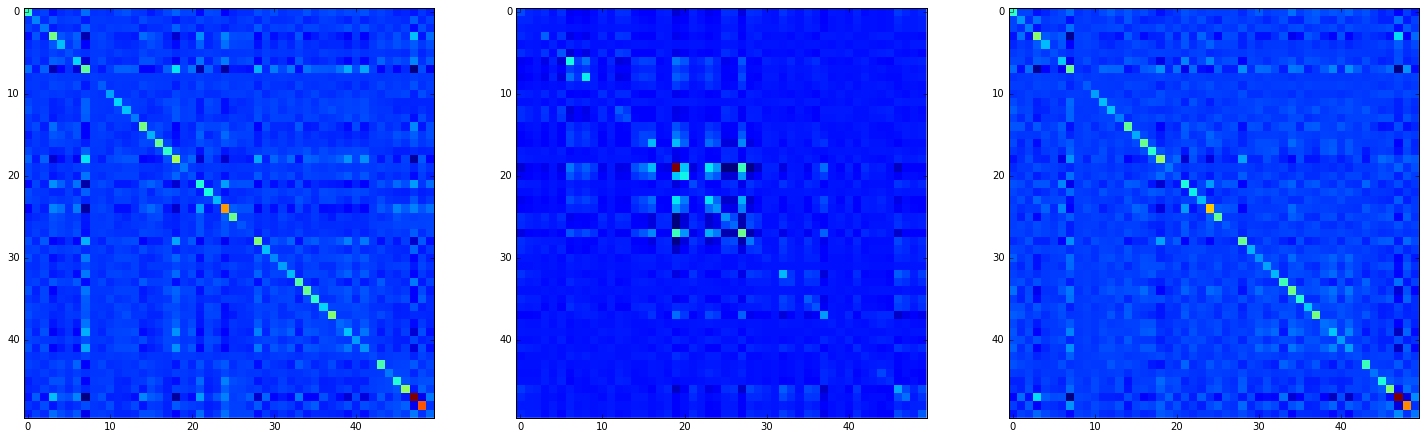

finished in 50 many steps.
('initialiser ', 'params_naive')
run #1/1
fitting #5
.........................  [ 25/50,    0.09sec avg, ETA 2.32 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.63 total



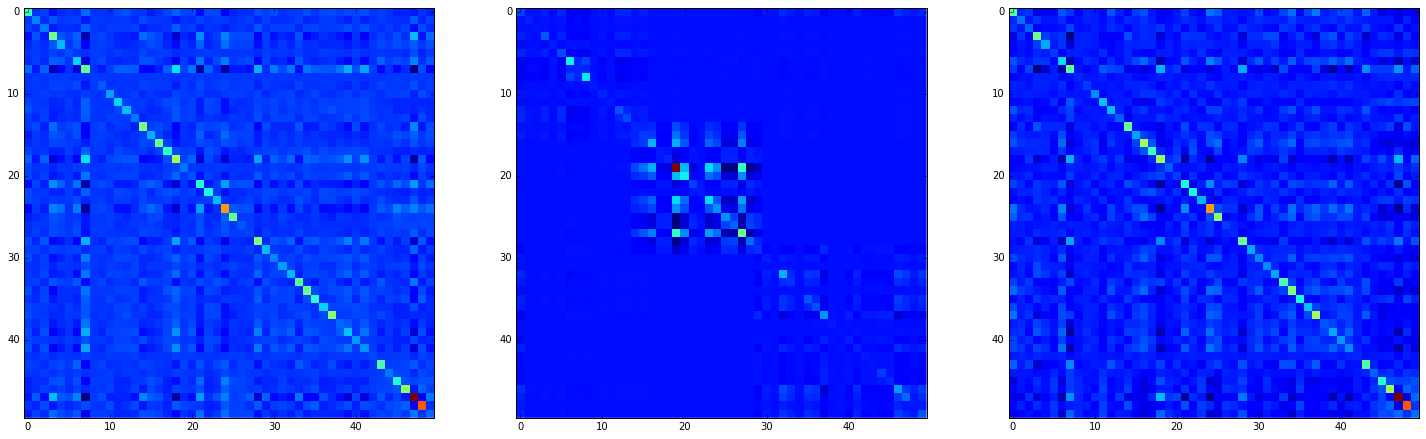

finished in 50 many steps.
('initialiser ', 'params_naive_flip')
run #1/1
fitting #5
.........................  [ 25/50,    0.09sec avg, ETA 2.28 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.40 total



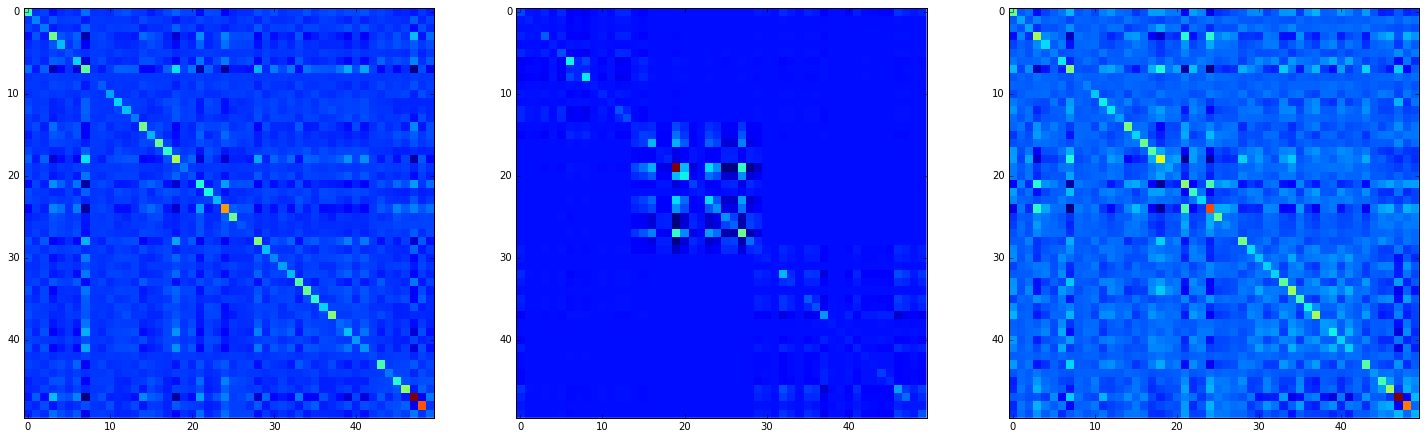

finished in 50 many steps.
('initialiser ', 'random')
run #1/5
fitting #5
.........................  [ 25/50,    0.11sec avg, ETA 2.77 ]
.........................  [ 50/50,    0.12sec avg, ETA 0.00 ]

   0.12sec avg, 6.14 total



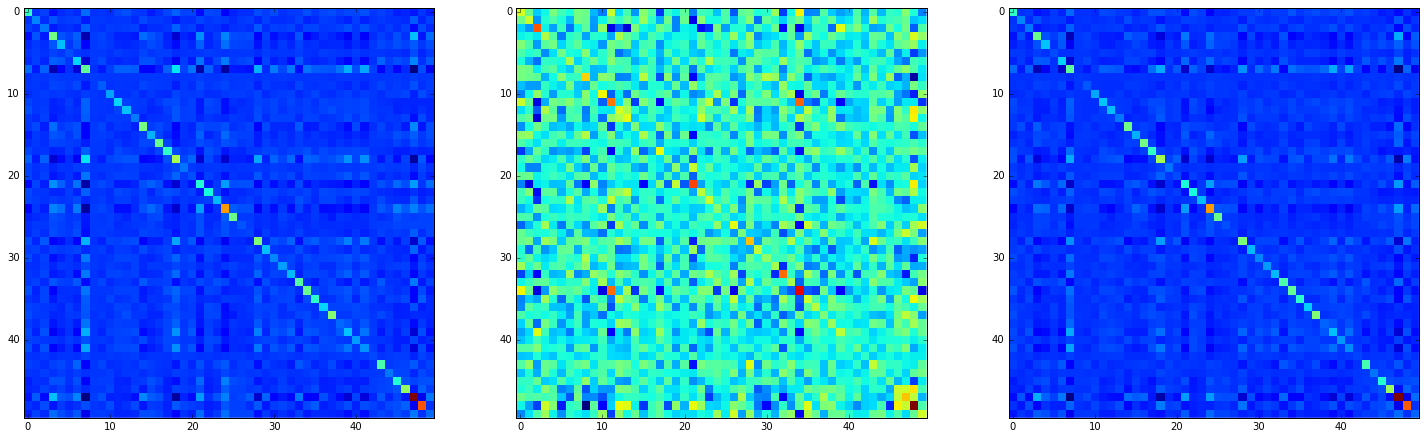

finished in 50 many steps.
run #2/5
fitting #5
.........................  [ 25/50,    0.14sec avg, ETA 3.39 ]
.........................  [ 50/50,    0.14sec avg, ETA 0.00 ]

   0.14sec avg, 6.76 total



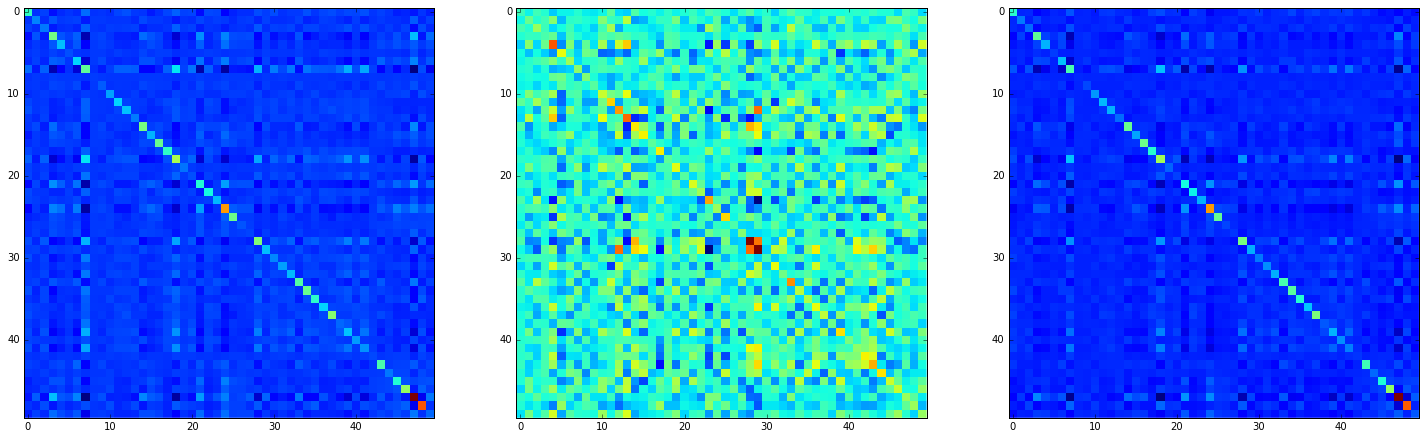

finished in 50 many steps.
run #3/5
fitting #5
.........................  [ 25/50,    0.13sec avg, ETA 3.37 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.74 total



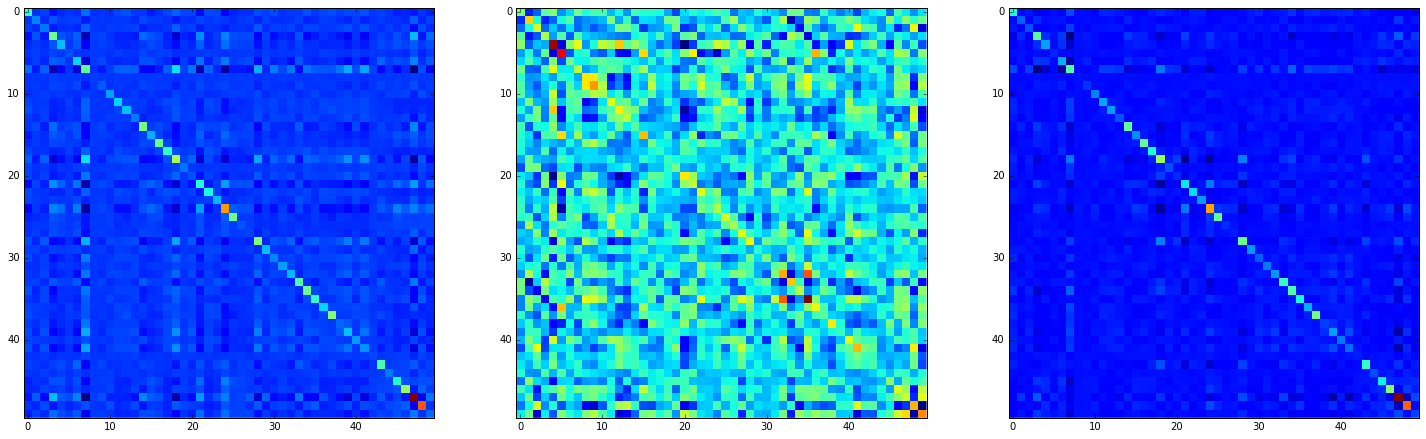

finished in 50 many steps.
run #4/5
fitting #5
.........................  [ 25/50,    0.13sec avg, ETA 3.37 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.74 total



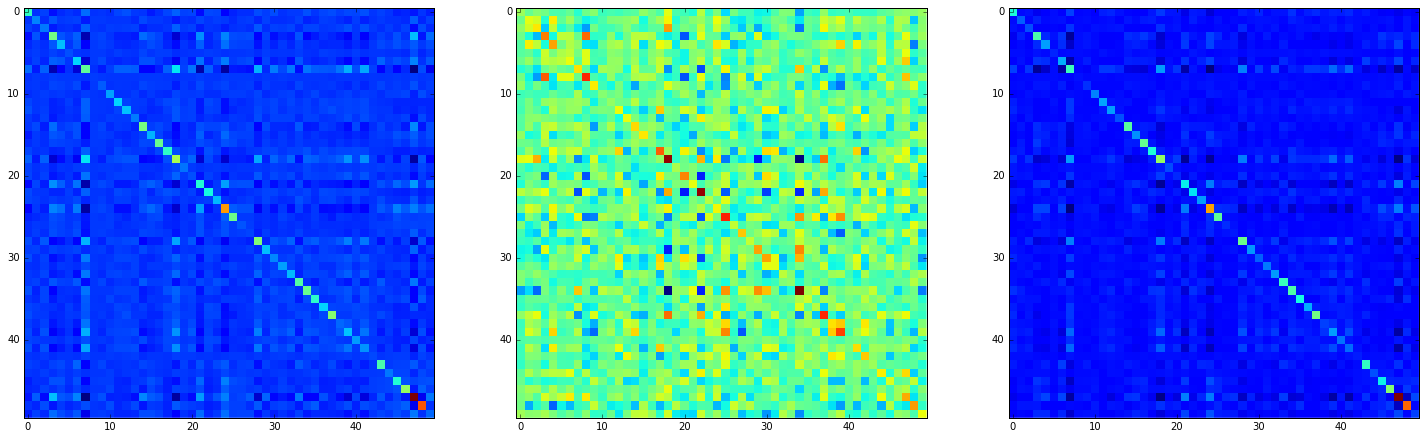

finished in 50 many steps.
run #5/5
fitting #5
.........................  [ 25/50,    0.13sec avg, ETA 3.37 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.74 total



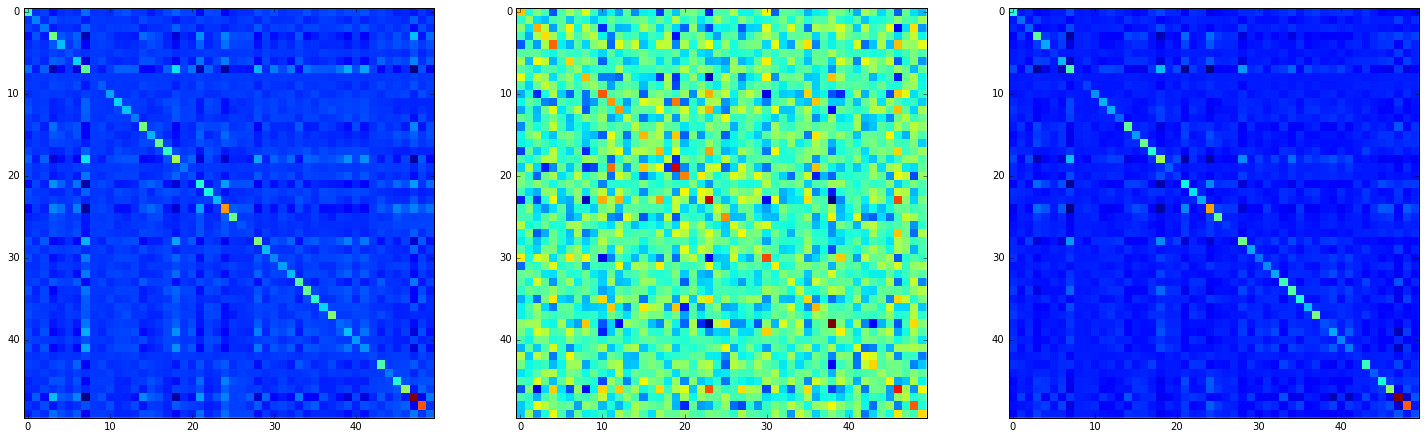

finished in 50 many steps.
('idx', 9)
LDS_save_idx9.npz
('dataset #', 9)
('(T, p, n, eps) = ', (5000, 50, 5, 0.009950330853168092))
prot 0/36
('initialiser ', 'params')
run #1/1
fitting #9
.........................  [ 25/50,    0.13sec avg, ETA 3.16 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.38 total



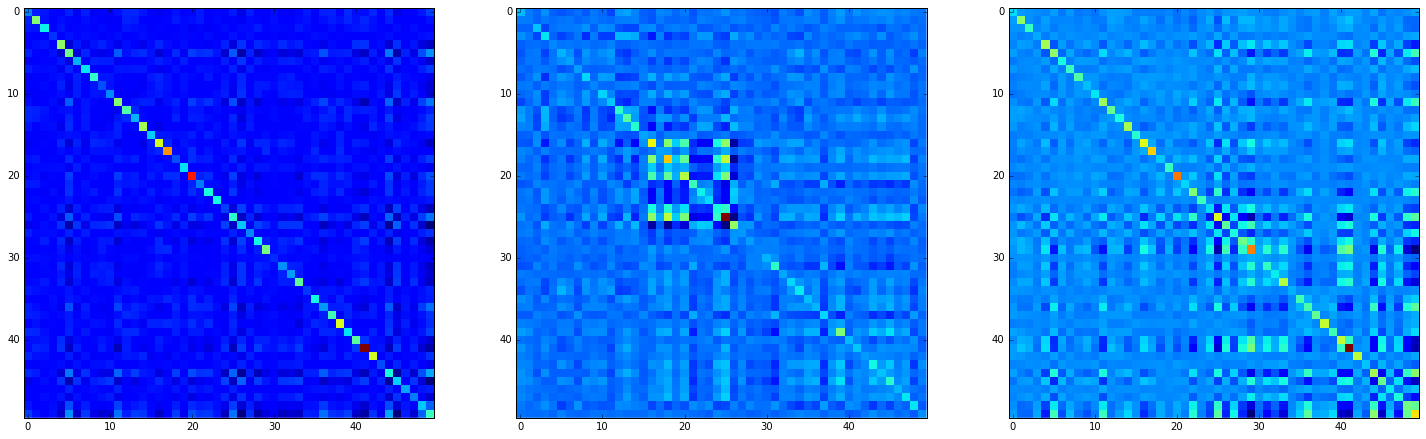

finished in 50 many steps.
('initialiser ', 'params_flip')
run #1/1
fitting #9
.........................  [ 25/50,    0.13sec avg, ETA 3.15 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.36 total



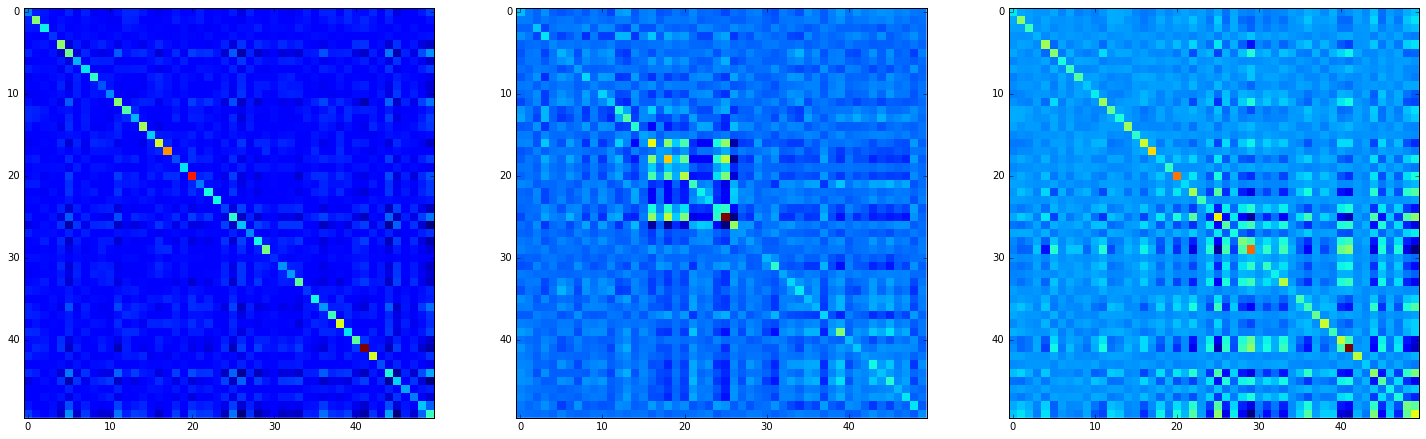

finished in 50 many steps.
('initialiser ', 'params_naive')
run #1/1
fitting #9
.
############
#RUN BROKE!#
############

finished in 1 many steps.
('initialiser ', 'params_naive_flip')
run #1/1
fitting #9
.
############
#RUN BROKE!#
############

finished in 1 many steps.
('initialiser ', 'random')
run #1/5
fitting #9
.........................  [ 25/50,    0.13sec avg, ETA 3.21 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.42 total



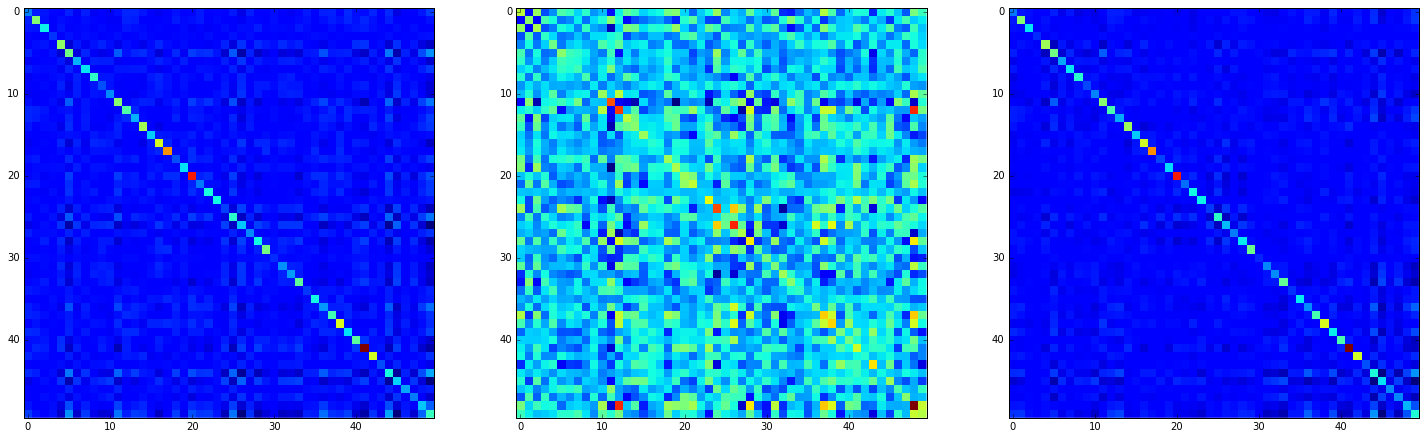

finished in 50 many steps.
run #2/5
fitting #9
.........................  [ 25/50,    0.13sec avg, ETA 3.21 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.41 total



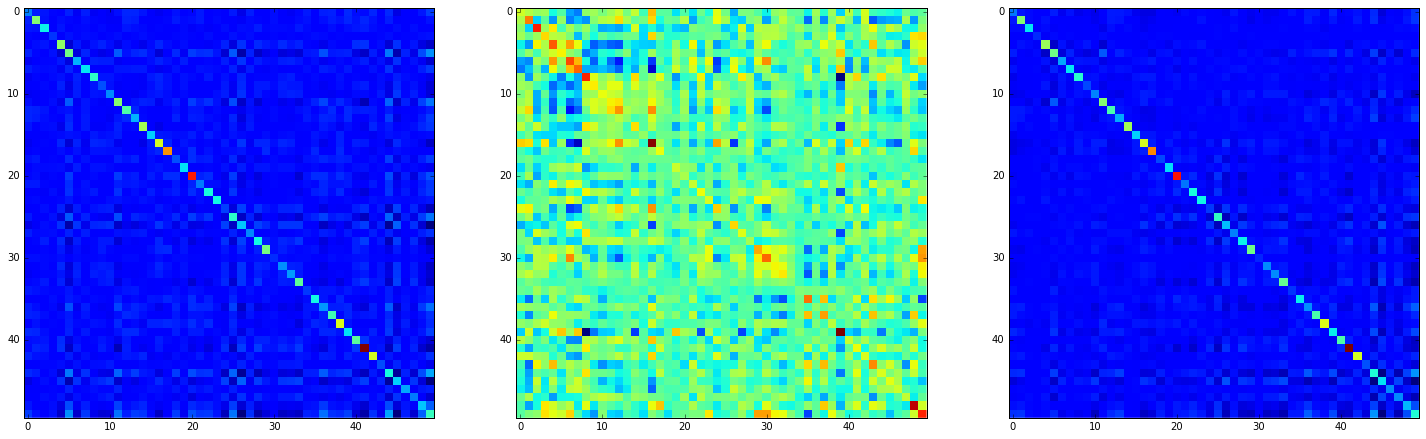

finished in 50 many steps.
run #3/5
fitting #9
.........................  [ 25/50,    0.10sec avg, ETA 2.43 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.51 total



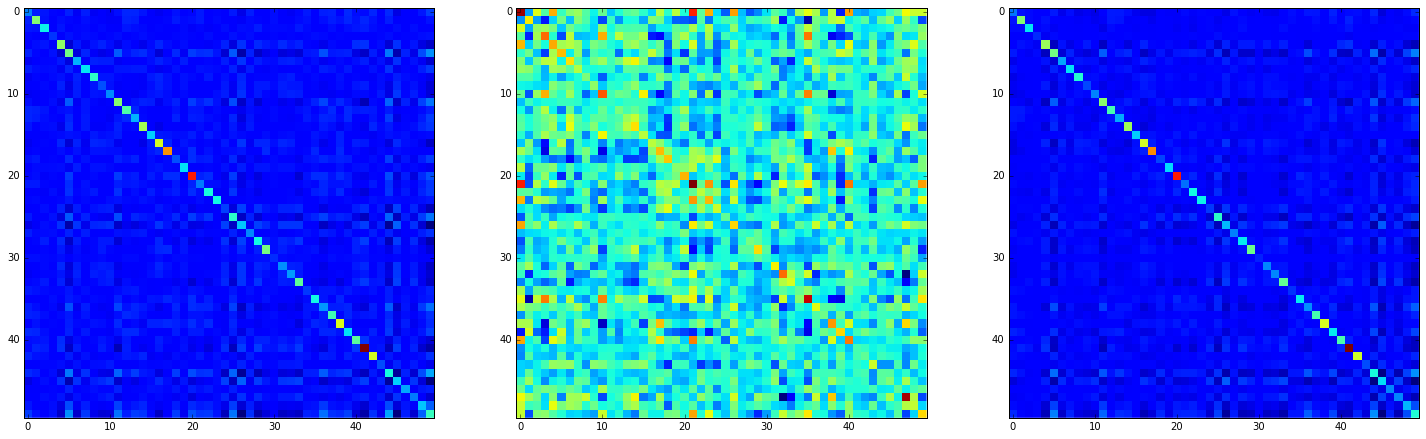

finished in 50 many steps.
run #4/5
fitting #9
.........................  [ 25/50,    0.08sec avg, ETA 2.08 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.16 total



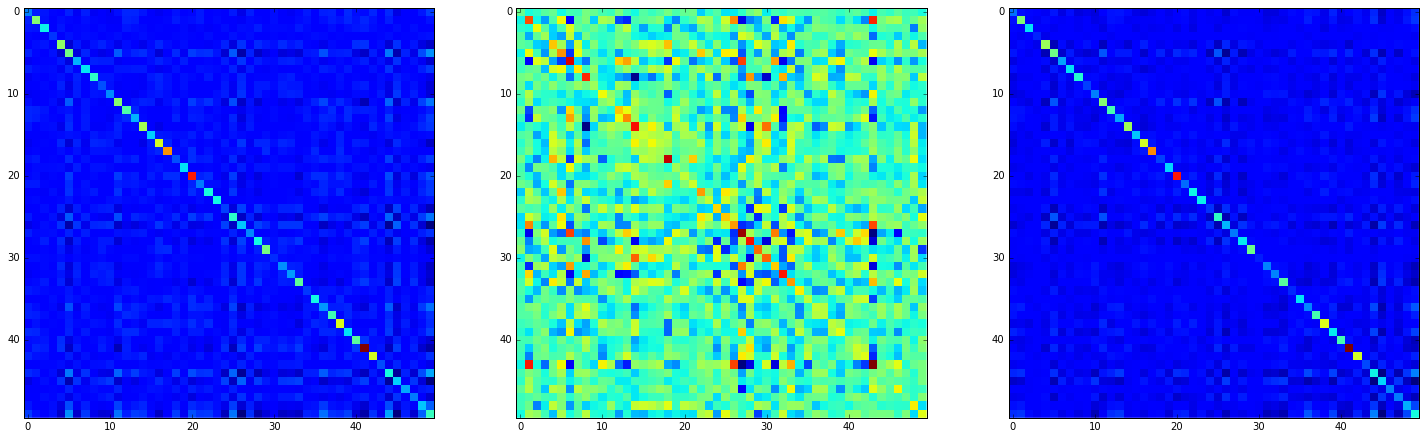

finished in 50 many steps.
run #5/5
fitting #9
.........................  [ 25/50,    0.08sec avg, ETA 2.08 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.15 total



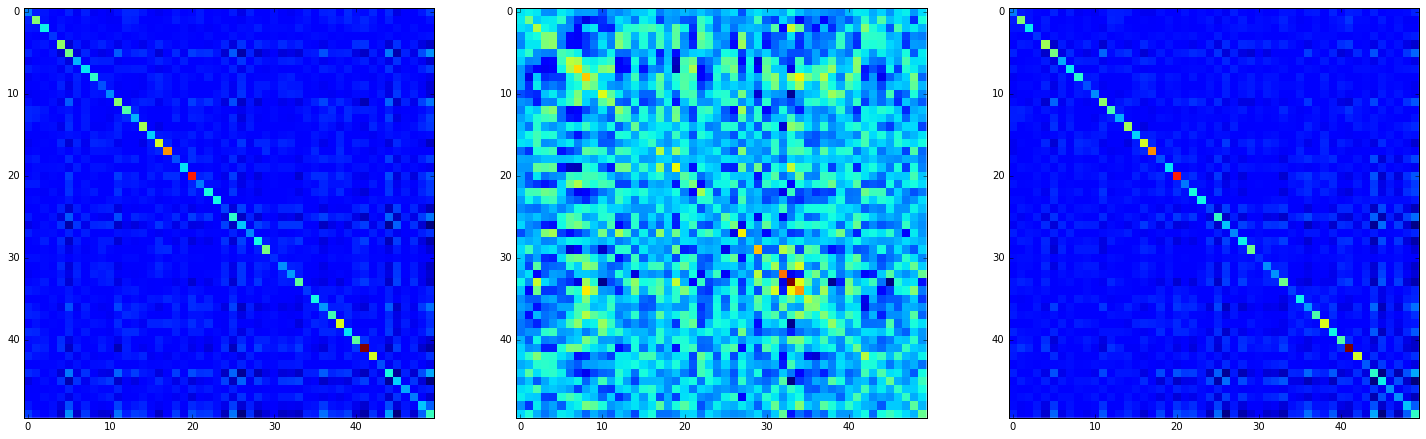

finished in 50 many steps.
prot 12/36
('initialiser ', 'params')
run #1/1
fitting #9
.........................  [ 25/50,    0.08sec avg, ETA 2.11 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.22 total



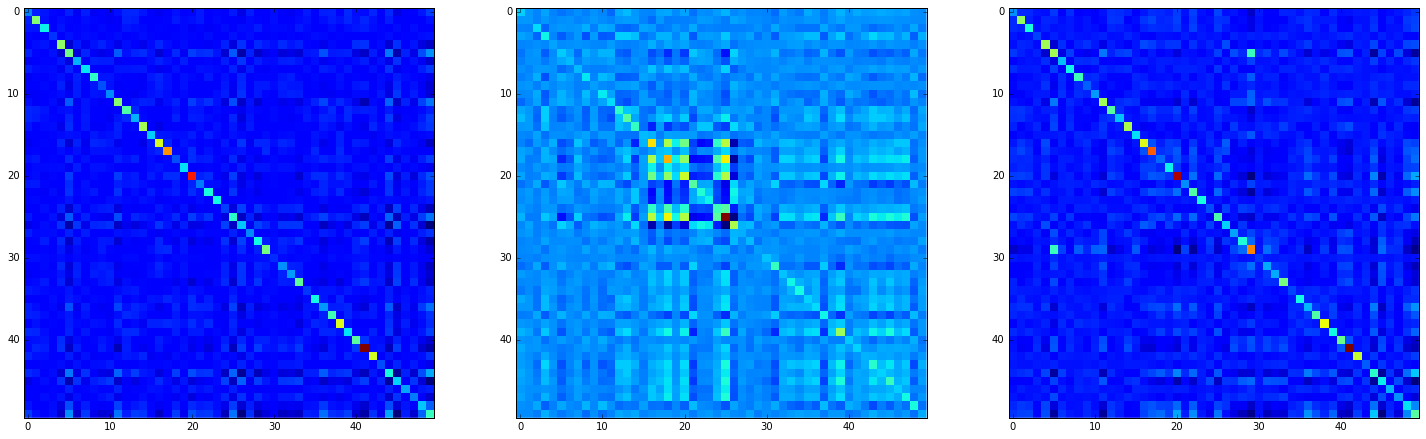

finished in 50 many steps.
('initialiser ', 'params_flip')
run #1/1
fitting #9
.........................  [ 25/50,    0.08sec avg, ETA 2.11 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.23 total



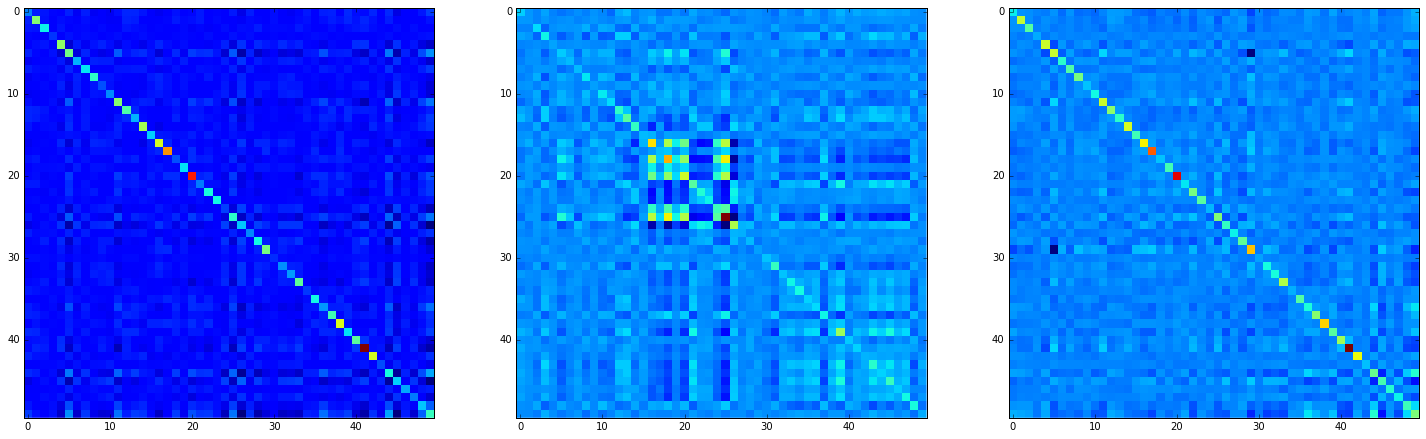

finished in 50 many steps.
('initialiser ', 'params_naive')
run #1/1
fitting #9
.........................  [ 25/50,    0.08sec avg, ETA 2.10 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.21 total



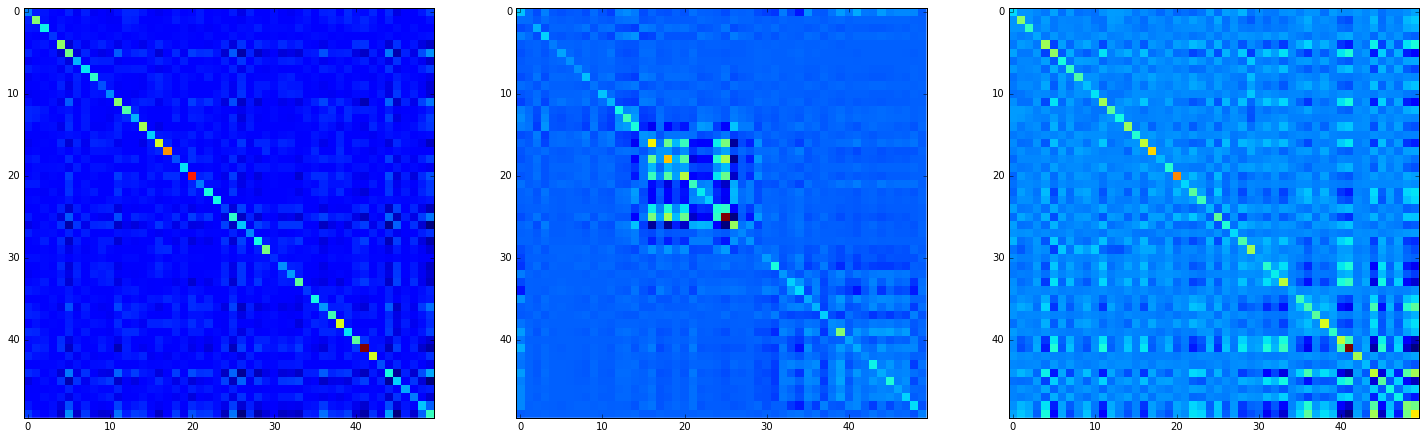

finished in 50 many steps.
('initialiser ', 'params_naive_flip')
run #1/1
fitting #9
.........................  [ 25/50,    0.08sec avg, ETA 2.12 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.23 total



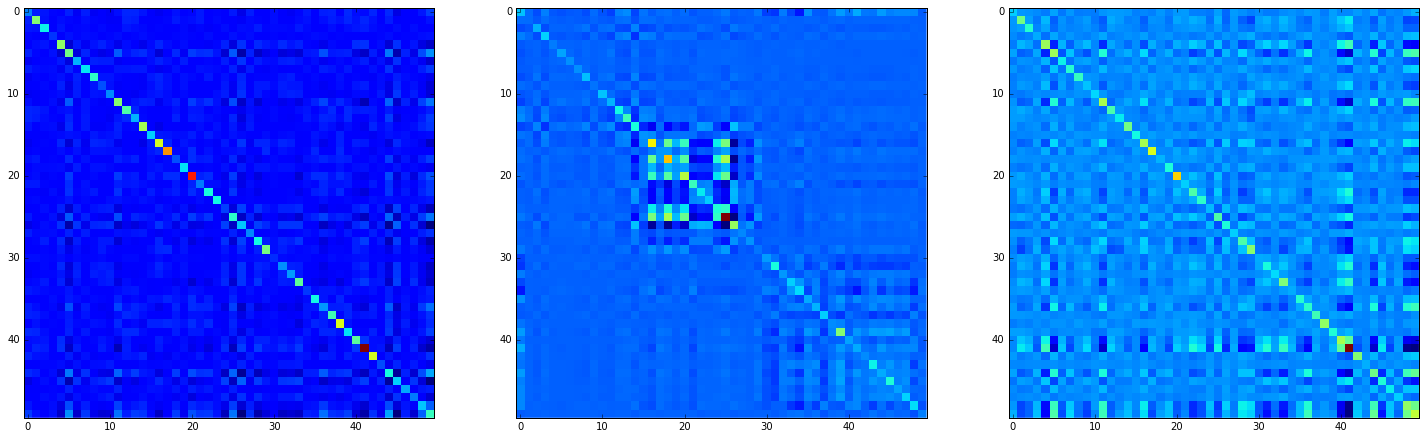

finished in 50 many steps.
('initialiser ', 'random')
run #1/5
fitting #9
.........................  [ 25/50,    0.08sec avg, ETA 2.12 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.23 total



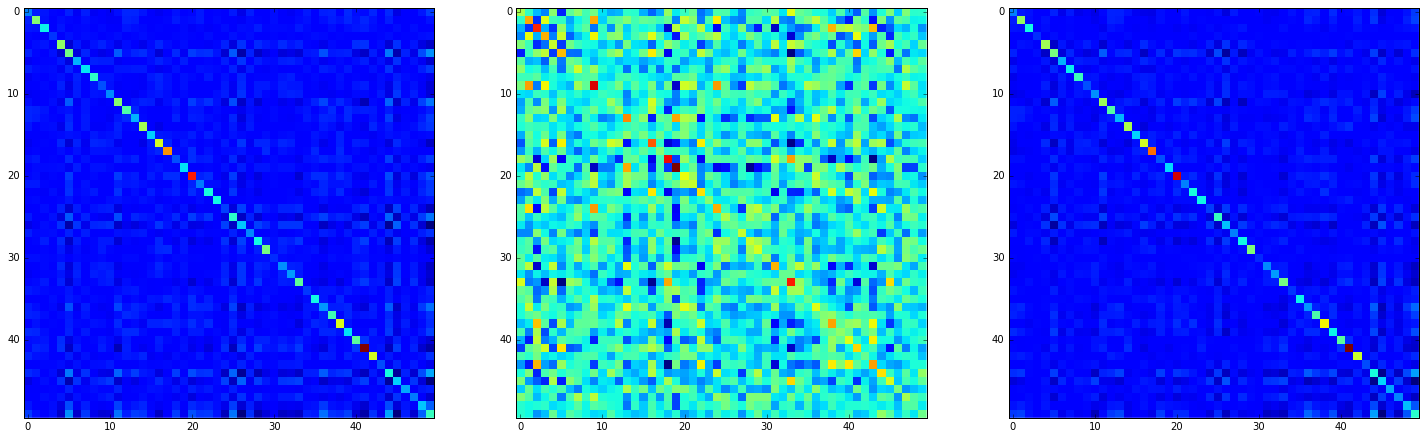

finished in 50 many steps.
run #2/5
fitting #9
.........................  [ 25/50,    0.11sec avg, ETA 2.67 ]
.........................  [ 50/50,    0.12sec avg, ETA 0.00 ]

   0.12sec avg, 6.00 total



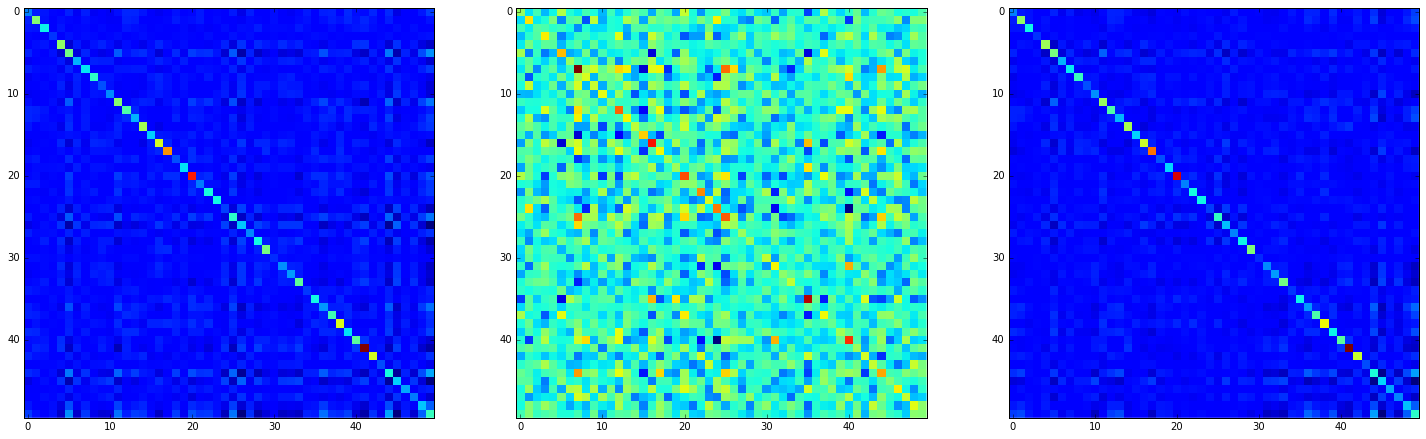

finished in 50 many steps.
run #3/5
fitting #9
.........................  [ 25/50,    0.13sec avg, ETA 3.33 ]
.........................  [ 50/50,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 6.64 total



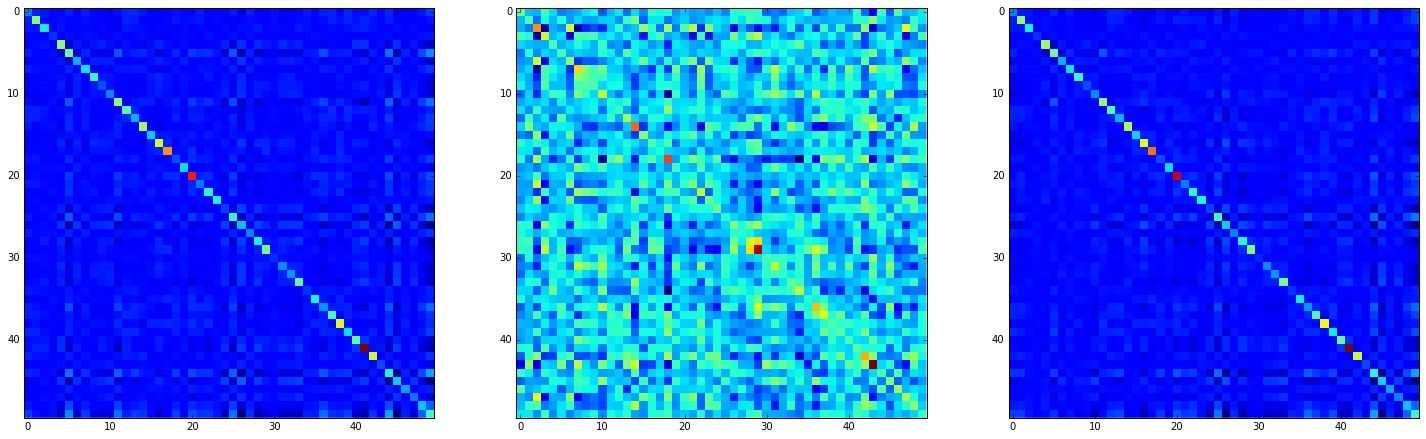

finished in 50 many steps.
run #4/5
fitting #9
.........................  [ 25/50,    0.10sec avg, ETA 2.57 ]
.........................  [ 50/50,    0.09sec avg, ETA 0.00 ]

   0.09sec avg, 4.68 total



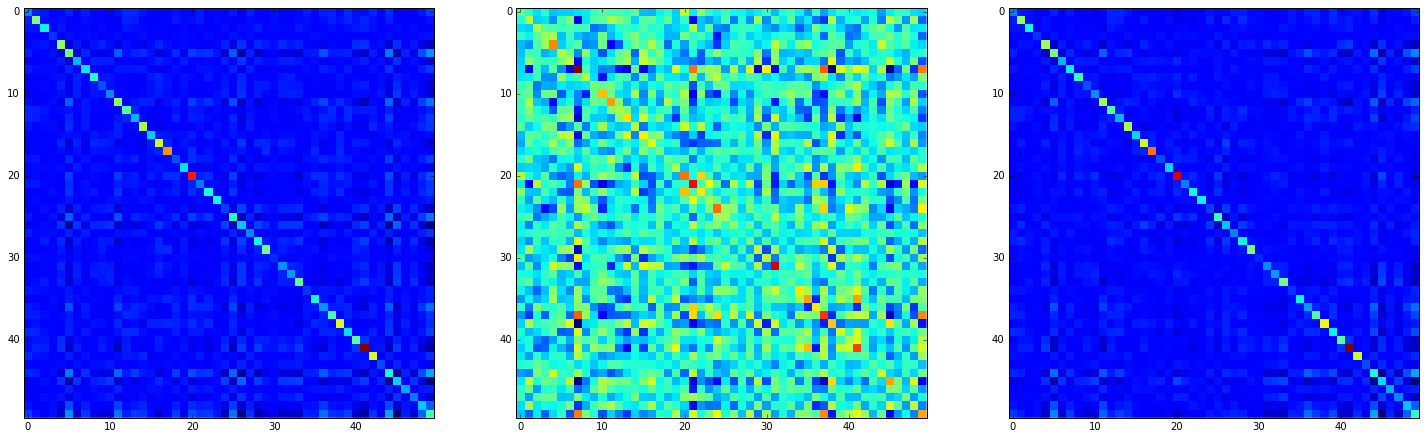

finished in 50 many steps.
run #5/5
fitting #9
.........................  [ 25/50,    0.08sec avg, ETA 2.12 ]
.........................  [ 50/50,    0.08sec avg, ETA 0.00 ]

   0.08sec avg, 4.23 total



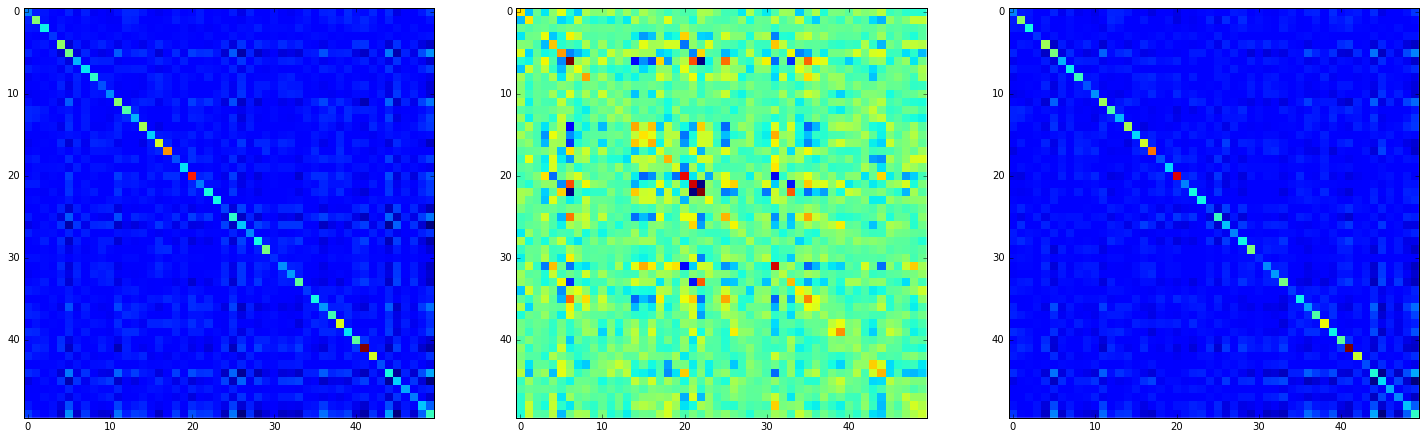

finished in 50 many steps.


In [2]:
%matplotlib inline
relative_data_path = '../../../results/cosyne_poster/simulation_2/data'
os.chdir(relative_data_path)
filenames = glob.glob("*.npz")
num_exps = len(filenames)
idx_exps = range(num_exps)
        
eps = np.log(1.01)
max_iter = 50

initialisers = ['params', 'params_flip', 'params_naive', 'params_naive_flip', 'random']

for idx in [0,2,5,9]:
    
    ##################
    # load the data  #
    ##################
    
    print('idx', idx)
    filename = 'LDS_save_idx' + str(idx) + '.npz'
    print(filename)

    os.chdir('../data/')    
    loadfile = np.load(filename)

    data = loadfile['y']
    T,p = data.shape
    n   = loadfile['x'].shape[1]
    
    pars_true = loadfile['truePars'].reshape(1,)[0] # some numpy (cross-version 3.x-2.x?)     
    tmp = {}
    for j in range(len(pars_true.keys())):
        tmp[str(pars_true.keys()[j])] =  pars_true.values()[j]
    pars_true = tmp    

    print('dataset #', idx)
    print('(T, p, n, eps) = ', (T, p, n, eps))
    
    ####################
    # pick initialiser #
    ####################

    os.chdir('../init/')
    initfiles = glob.glob("*_LDS_save_idx" + str(idx) + ".npz")
    num_prots = len(initfiles)
    
    for prot in [0,12]: #range(num_prots):
        
        initfile = initfiles[prot]
        print('prot ' + str(prot) + '/' + str(num_prots))
        os.chdir('../init/')
        loadinit = np.load(initfile)

        obs_scheme = ObservationScheme(p=p, T=T, 
                                   sub_pops=tuple([item for item in loadinit['sub_pops']]),
                                   obs_pops=loadinit['obs_pops'], 
                                   obs_time=loadinit['obs_time'])
        
        for initialiser in initialisers:

            print('initialiser ', initialiser)
            if initialiser in ['params', 'params_flip', 'params_naive', 'params_naive_flip']:
                
                num_repets = 1
                initkey =  initialiser[:-5] if initialiser[-5:]=='_flip' else initialiser

                pars_init = loadinit[initkey].reshape(1,)[0]
                tmp = {}
                for j in range(len(pars_init.keys())):
                    tmp[str(pars_init.keys()[j])] =  pars_init.values()[j]
                pars_init = tmp    

                pars_init['R'] = np.diag(pars_init['R'])

                # for SSID-derived initialisers, also try out flipping parts of C
                if initialiser[-5:]=='_flip':
                    idx0_no_overlap = np.setdiff1d(np.arange(p),obs_scheme.sub_pops[1]) 
                    pars_init['C'][idx0_no_overlap,:] *= -1


            elif initialiser=='random':

                num_repets = 5

            else:
                raise Exception('unexpected initialiser!')


            for repet in range(num_repets):

                print( 'run #' + str(repet+1) +'/' +str(num_repets) )

                if initialiser=='random':

                    pars_init, _ = gen_pars(n, p, u_dim=0, 
                                         pars_in=None, 
                                         obs_scheme=obs_scheme,
                                         gen_A='diagonal', lts=0.99 * np.ones((n,)),
                                         gen_B='random', 
                                         gen_Q='identity', 
                                         gen_mu0='random', 
                                         gen_V0='identity', 
                                         gen_C='random', 
                                         gen_d='mean', 
                                         gen_R='fractionObserved',
                                         diag_R_flag=True,
                                         x=None, y=data.T, u=None)    

                ###################
                #    EM cycles    #
                ###################
                likes = [-np.inf]
                try:
                    # get EM-step results after m iterations                    
                    model = init_LDS_model(pars_init, data, obs_scheme) # reset to initialisation                    
                    print 'fitting #' + str(idx)    
                    for t in progprint_xrange(max_iter):
                        likes.append(update(model))
                        if likes[-1]-likes[-2] < eps:
                            break

                    stats_hat,pars_hat = collect_LDS_stats(model)

                    # get EM-step results from true parameters
                    model = init_LDS_model(pars_true, data, obs_scheme) # reset to true pars
                    model.E_step()
                    stats_true,_ = collect_LDS_stats(model)
                    model.M_step()

                    broken = False
                    Pi = dtlyap(pars_true['A'], pars_true['Q'])
                    Pi_h = dtlyap(pars_hat['A'], pars_hat['Q'])
                    Pi_t = pars_true['A'].dot(dtlyap(pars_true['A'], pars_true['Q']))
                    Pi_t_h = pars_hat['A'].dot(dtlyap(pars_hat['A'], pars_hat['Q']))


                except:
                    print('')
                    print('############')
                    print('#RUN BROKE!#')
                    print('############')
                    print('')

                    broken = True
                    pars_hat, stats_hat, stats_true = [],[],[]
                    Pi, Pi_h, Pi_t, Pi_t_h = 0,0,0,0
                    
                if not broken:
                    plt.figure(figsize=(25,25))
                    plt.subplot(1,3,1)
                    plt.imshow(np.cov(data.T),interpolation='none')
                    plt.subplot(1,3,2)
                    if initialiser=='random':
                        pars_init['Pi'] = dtlyap(pars_init['A'], pars_init['Q'])
                        R = pars_init['R']
                    else:
                        R = np.diag(pars_init['R'])
                    plt.imshow(pars_init['C'].dot(pars_init['Pi']).dot(pars_init['C'].T) + R,interpolation='none')
                    plt.subplot(1,3,3)
                    plt.imshow(pars_hat['C'].dot(Pi_h).dot(pars_hat['C'].T) + pars_hat['R'],interpolation='none')   
                    plt.show()

                ###################
                #  store results  #
                ###################

                print('finished in ' + str(len(likes)-1) + ' many steps.')

                os.chdir('../fits/')

                save_file = initialiser + '_prot' + str(prot) + '_rep' + str(repet) + '_' + filename

                save_file_m = {'ifBroken':broken,
                               'll' : likes, 
                               'T' : T, 
                               'Trial': 1, 
                               'ifUseB':False, 
                               'ifUseA':True, 
                               'epsilon':eps,
                               'truePars':pars_true,
                               'initPars':pars_init,
                               'estPars': pars_hat,
                               'stats_h': stats_hat,
                               'stats_true': stats_true,
                               'Pi':Pi,
                               'Pi_h':Pi_h,
                               'Pi_t':Pi_t,
                               'Pi_t_h':Pi_t_h,
                               'sub_pops':obs_scheme.sub_pops,            
                               'obs_time':obs_scheme.obs_time,            
                               'obs_pops':obs_scheme.obs_pops}
                savemat(save_file,save_file_m) # does the actual saving

                np.savez(save_file, 
                        broken=broken,
                        ll=likes,
                        T=T, 
                        Trial=1, 
                        ifUseA=True,
                        ifUseB=False,
                        epsilon=eps,
                        initPars=pars_init,
                        truePars=pars_true,
                        estPars =pars_hat,
                        stats_h = stats_hat,
                        stats_true = stats_true,
                        Pi=Pi,
                        Pi_h=Pi_h,
                        Pi_t=Pi_t,
                        Pi_t_h=Pi_t_h,
                        sub_pops=obs_scheme.sub_pops,            
                        obs_time=obs_scheme.obs_time,            
                        obs_pops=obs_scheme.obs_pops)     

